# Using Data Science to understand the Hollywood Gender Gap

### Imports

In [1105]:
# firstnames = SFrame.read_csv(f"{DATA_PATH}/firstnames.csv")["Name"]
# surenames = SFrame.read_csv(f"{DATA_PATH}/surenames.csv")["name"]
# surenames = surenames.apply(lambda n: n.title())
# sf = SFrame.read_csv(f"{TEMP_PATH}/title.principals.tsv.gz", delimiter="\t", column_type_hints={"characters": list},
#                      na_values=["\\N"])
# sf = sf.filter_by(["actor", "actress"], "category")["tconst", "ordering", "characters", "nconst"]
# sf = sf.stack("characters", "character")
# sf["character"] = sf["character"].apply(lambda c: c.title())
# sf = sf.groupby(key_column_names=['character', "nconst"],
#                 operations={'ordering': agg.AVG("ordering"), 'count': agg.COUNT()})
# sf = sf[sf['ordering'] > 4]
# sf = sf.groupby(key_column_names='character',
#                 operations={'averageOrder': agg.AVG("ordering"), 'count': agg.COUNT()})
# sf["name"] = sf["character"].apply(lambda c: c.split(" ")[-1].strip())
sf = sf.filter_by(names.words(), "name", exclude=True)
sf = sf.filter_by(surenames, "name", exclude=True)
sf = sf.filter_by(firstnames, "name", exclude=True)
sf = sf.sort("count", False)
w = [x.title() for x in words.words()]
# sf = sf[sf['count'] > 11].append(sf[sf['count'] < 10].filter_by(w, "name"))
# sf.export_csv(f"{TEMP_PATH}/roles.csv")

In [1163]:
sf["set"] = sf["character"].apply(lambda x: set(x.split(" ")))

In [1168]:
sf["character"].save("blacklist_roles.csv", "csv")

In [1165]:
w = {x.title() for x in wordnet.words()}

In [1153]:
sf["set"] = sf["set"].apply(lambda x: w & set(x))

In [1]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib inline  

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [3]:
import pandas as pd
from tqdm import tqdm
import math

In [4]:
import numpy as np

In [1100]:
from subs2graph.consts import TEMP_PATH, DATA_PATH

## Introduction

In the past couple of years we have heard many stories about women discrimination is the film industry.
Even worse there was many reports of women sexual harassments in Hollywood which has led to the rise of the MeToo Movement.
This paper, investigates the gender gap in Hollywood utilizing data science techniques. 

## File Genartion

In [48]:
from subs2graph.videos_sn_creator import generate_actors_file
generate_actors_file()

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/dogpile/cache/util.py:31: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args = inspect.getargspec(fn)


Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/title.principals.tsv.gz

Parsing completed. Parsed 100 lines in 1.15453 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,int,str,str,str,list]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 1190442 lines. Lines per second: 842553

Read 9496862 lines. Lines per second: 1.44595e+06

Read 17696093 lines. Lines per second: 1.42837e+06

Read 24787792 lines. Lines per second: 1.40824e+06

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/title.principals.tsv.gz

Parsing completed. Parsed 30924394 lines in 22.0332 secs.

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/name.basics.tsv.gz

Parsing completed. Parsed 100 lines in 1.28029 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,str,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 686206 lines. Lines per second: 444927

Read 5697715 lines. Lines per second: 847489

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/name.basics.tsv.gz

Parsing completed. Parsed 8957228 lines in 9.8421 secs.

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/title.ratings.tsv.gz

Parsing completed. Parsed 100 lines in 0.355944 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,float,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/title.ratings.tsv.gz

Parsing completed. Parsed 883732 lines in 0.399085 secs.

AttributeError: 'IMDbDatasets' object has no attribute '_title'

## Analysis


<img src="https://i.kym-cdn.com/entries/icons/mobile/000/027/456/kowalski.jpg" />


In [1291]:
from subs2graph.graph_analyzer import *

### Load actors-movies list

In [1015]:
actors = pd.read_csv(f"{TEMP_PATH}/actors.csv",index_col=0 )
actors = actors.drop(["endYear", "isAdult", "knownForTitles", "originalTitle", "titleType"], axis=1)

In [1016]:
len(actors["nconst"].unique())

1651

In [1017]:
len(actors["tconst"].unique())

7717

In [1018]:
len(actors[actors["gender"]=="F"]["nconst"].unique())

563

In [1019]:
actors.head(1)

,averageRating,birthYear,count,deathYear,gender,genres,nconst,path,primaryName,primaryProfession,primaryTitle,runtimeMinutes,startYear,tconst
0,8.533333,1930,6,1987,F,"Comedy,Family,Romance",nm0621870,/Users/dimakagan/Projects/subs2graph/temp/movi...,Adile Nasit,actress,Sultan,88.0,1978.0,tt0264051


### Join with movies meta data

In [1020]:
def analyze_actors():
    p = f"{TEMP_PATH}/movies/"
    res = []
    for i, a in tqdm(actors.iterrows()):
        g_pth = a["path"]
        try:
            with open(glob.glob(os.path.join(f"{g_pth}/json", f"*roles*"))[0]) as f:
                g = json_graph.node_link_graph(json.load(f))
                if g.number_of_nodes() < 6:
                    continue
                d = get_actor_features(g, a["primaryName"])
            res.append({**d, **a})
        except KeyError:
            pass

    return res

In [1172]:
actors_features =  pd.DataFrame(analyze_actors())

18420it [02:48, 109.48it/s]


In [1173]:
actors_features = actors_features.drop("count", axis=1)

In [1174]:
len(actors_features)

11981

In [1175]:
actors_features = actors_features.sort_values("nconst")

### Feature Engineering 

Graph based:

In [1176]:
graph_features = ["betweenness", "closeness", 'clustering','degree', 'degree_centrality','total_weight']

Date based features:

In [1177]:
actors_features = actors_features.replace("\\N", 0)
actors_features = actors_features.dropna()
actors_features["deathYear"] = actors_features["deathYear"].astype(int)
actors_features["birthYear"] = actors_features["birthYear"].astype(int)
actors_features["startYear"] = actors_features["startYear"].astype(int)
actors_features["age_filming"] = actors_features["startYear"] - actors_features["birthYear"]

In [1178]:
actors_features = actors_features[actors_features["birthYear"]!=0]

Multiple categories to onehot

In [1179]:
# actors_features["primaryProfession"] = actors_features["primaryProfession"].apply(lambda x: x.split(","))
actors_features["genres"] = actors_features["genres"].apply(lambda x: x.split(","))

In [1180]:
genres = set()
for genre in set().union(*actors_features.genres.values):
    actors_features[genre] = actors_features.apply(lambda _: int(genre in _.genres), axis=1)
    genres.add(genre)
    
# for prof in set().union(*actors_features.primaryProfession.values):
#     actors_features[prof] = actors_features.apply(lambda _: int(prof in _.primaryProfession), axis=1)

Gender to numeric - Male=1 Female=0

In [1181]:
actors_features["gender_num"] = actors_features["gender"].apply(lambda x: 1 if x == "M" else 0)

### ML

In [1182]:
df = actors_features.drop(["gender","genres","path","primaryName","primaryProfession","primaryTitle", "tconst"], axis=1)

In [1183]:
male =  df[df["gender_num"]==1]
female = df[df["gender_num"]==0]

In [1236]:
male["nconst"].nunique()

1046

In [1237]:
female["nconst"].nunique()

548

In [1184]:
def split_vals(a, n): return a[:n].copy(), a[n:].copy()

In [1185]:
def rmse(x, y): return math.sqrt(((x-y)**2).mean())
 

def print_score(m, X_train, y_train, X_valid, y_valid):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)

Imbalanced Dataset:

In [1186]:
len(actors_features[actors_features["gender"]=="M"])

7916

In [1187]:
len(actors_features[actors_features["gender"]=="F"])

4060

In [1188]:

# balanced_df = male.sample(len(female)).append(female)
# balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

In [1189]:
male_sample = male.sort_values("nconst")[:len(female)]
n_valid = 2000
male_sample = male_sample.drop(["nconst", "gender_num"], axis=1)
female_sample = female.drop(["nconst", "gender_num"], axis=1)
male_train, male_valid = split_vals(male_sample, n_valid//2)
female_train, female_valid = split_vals(female_sample, n_valid//2)

In [1190]:
X_train = male_train.append(female_train)
X_valid = male_valid.append(female_valid)
y_train = np.concatenate((np.ones(len(male_train)), np.zeros(len(female_train))))
y_valid = np.concatenate((np.ones(len(male_valid)), np.zeros(len(female_valid))))

In [1191]:
# y = balanced_df.pop("gender_num")
# n_valid = 2000  # same as Kaggle's test set size
# n_trn = len(balanced_df)-n_valid
# X_train, X_valid = split_vals(balanced_df, n_trn)
# y_train, y_valid = split_vals(y, n_trn)

In [1192]:
# balanced_df.to_csv("../mf_balanced.csv", index=False)
# balanced_df[graph_features+["gender_num"]].to_csv("../mf_balanced_graph.csv", index=False)
# balanced_df.drop(graph_features, axis=1).to_csv("../mf_balanced_not_graph.csv", index=False)

In [1193]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn import metrics

In [1194]:
m = RandomForestClassifier(n_jobs=-1, max_features=0.9, n_estimators=100)
m.fit(X_train[graph_features], y_train)
print_score(m, X_train[graph_features], y_train, X_valid[graph_features], y_valid)

[0.06324555320336758, 0.6861134264732969, 0.996, 0.5292483660130719]


In [1195]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_valid, m.predict_proba(X_valid[graph_features])[:, 1])

0.533531814686659

In [1196]:
other_features = list(set(X_train.columns.values) - set(graph_features))
m = RandomForestClassifier(n_jobs=-1)
m.fit(X_train[other_features], y_train)
print_score(m, X_train[other_features], y_train, X_valid[other_features], y_valid)

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.05477225575051661, 0.6062043056022606, 0.997, 0.632516339869281]


all

In [1197]:
best_features = X_train.columns.values

In [1198]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=50, max_features=0.5 , min_samples_split=5, min_samples_leaf=25)
m.fit(X_train[best_features], y_train)
print_score(m, X_train[best_features], y_train, X_valid[best_features], y_valid)

[0.3687817782917155, 0.5969694707601116, 0.864, 0.6436274509803922]


In [1199]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_valid, m.predict_proba(X_valid[best_features])[:, 1])

0.7526136849075142

What is important?

In [1200]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index=best_features,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
birthYear,0.418360
averageRating,0.277266
age_filming,0.120025
pagerank_weight,0.028717
betweenness,0.022661
startYear,0.018769
closeness,0.014916
total_weight,0.014410
clustering,0.013126
pagerank,0.010923


In [1201]:
best_features = list(feature_importances[feature_importances["importance"] > 0].index)

In [1202]:
male_sample = male.sort_values("nconst")[:len(female)]
leave_one_data = male_sample.append(female)
leave_one_data = leave_one_data.sort_values("nconst")

groups = leave_one_data.nconst.astype("category").cat.codes
y = leave_one_data.pop("gender_num")
X = leave_one_data.drop(["nconst"], axis=1)


In [45]:
from sklearn.model_selection import LeaveOneGroupOut

# X = [1, 5, 10, 50, 60, 70, 80]
# y = [0, 1, 1, 2, 2, 2, 2]
# groups = [1, 1, 2, 2, 3, 3, 3]
logo = LeaveOneGroupOut()
loo_split = logo.split(X, y, groups=groups)
# count = 0
# for train, test in loo_split:
#     print("%s %s" % (train, test))
#     if count == 5:
#         break
#     count += 1

In [803]:
from sklearn.metrics import confusion_matrix
# A sample toy binary classification dataset
from sklearn.metrics import make_scorer

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),
           'fp': make_scorer(fp), 'fn': make_scorer(fn)}

In [807]:
from sklearn import model_selection
scoring = ['accuracy', 'precision', 'recall']
model = RandomForestClassifier(n_jobs=-1, max_features=0.9, n_estimators=50)
results = model_selection.cross_validate(model, X[, y, cv=loo_split, scoring=scoring)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due 

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to 

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


AttributeError: 'DeprecationDict' object has no attribute 'mean'

In [46]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score

In [47]:
def get_classification_metrics(l_test, prediction, probas):
    # fpr, tpr, thresholds = roc_curve(l_test, prediction)
    false_positive = float(
        len(np.where(l_test - prediction == -1)[0]))  # 0 (truth) - 1 (prediction) == -1 which is a false positive
    true_negative = float(
        len(np.where(l_test + prediction == 0)[0]))  # 0 (truth) - 0 (prediction) == 0 which is a true positive
    return {"auc": roc_auc_score(l_test, probas),
            "recall": recall_score(l_test, prediction),
            "precision": precision_score(l_test, prediction),
            "accuracy": accuracy_score(l_test, prediction),
            "fpr": false_positive / (true_negative + false_positive),
            "tnr": true_negative / (true_negative + false_positive)
            }

In [48]:
def cross_validate(X, y):
    # clf = SkLearner(clone(self._classifier), self._label_encoder)
    roc_auc, recall, precision, accuracy, fpr, tpr, tnr = [], [], [], [], [], [], []
    all_probas =[]
    for train_index, test_index in loo_split:
        f_train, f_test = X.iloc[train_index], X.iloc[test_index]
        l_train, l_test = y.iloc[train_index], y.iloc[test_index]
        # prediction = self.train_classifier(DataSet(f_train, l_train)).predict(f_test)
        clf = RandomForestClassifier(n_jobs=-1, max_features=0.9, n_estimators=100)
        clf.fit(f_train, l_train)
        probas = clf.predict_proba(f_test)[:, 1]
        all_probas.append(probas)
    # return {"auc": np.mean(roc_auc)}
    # print classification_report(l_test, prediction)
    # print "Predicted: 0   1"
    # print confusion_matrix(l_test, prediction)
    return all_probas
#     return {"auc": np.mean(roc_auc), "recall": np.mean(recall), "precision": np.mean(precision),
#             "accuracy": np.mean(accuracy), "fpr": np.mean(fpr), "tnr": np.mean(tnr)}

In [49]:
res = cross_validate(X,y)

In [50]:
res_p = np.concatenate(res)

In [51]:
prediction = np.where(res_p > 0.5, 1, 0)

In [52]:
len(res_p)

7390

In [53]:
get_classification_metrics(y,prediction ,res_p)

{'auc': 0.8005875987189653,
 'recall': 0.7309878213802435,
 'precision': 0.7183510638297872,
 'accuracy': 0.722192151556157,
 'fpr': 0.2866035182679296,
 'tnr': 0.7133964817320704}

### Statistics

#### Males

In [120]:
male.describe().T

,count,mean,std,min,25%,50%,75%,max
averageRating,8205.0,6.563888,0.454584,3.850000,6.300000,6.573333,6.826316,8.335294
betweenness,8205.0,0.198978,0.245966,0.000000,0.000952,0.093939,0.316919,1.000000
birthYear,8205.0,1957.041316,51.802972,-1.000000,1948.000000,1961.000000,1971.000000,2006.000000
closeness,8205.0,0.740588,0.184065,0.050000,0.600000,0.750000,0.888889,1.000000
clustering,8205.0,0.500291,0.323257,0.000000,0.266667,0.500000,0.733333,1.000000
count,8205.0,21.944546,13.798410,6.000000,10.000000,19.000000,30.000000,75.000000
deathYear,8205.0,214.999147,620.872866,-1.000000,-1.000000,-1.000000,-1.000000,2018.000000
degree,8205.0,7.099939,5.177353,1.000000,3.000000,6.000000,10.000000,56.000000
degree_centrality,8205.0,0.633667,0.288870,0.011765,0.400000,0.666667,0.875000,3.000000
runtimeMinutes,8205.0,111.824254,21.276988,63.000000,97.000000,108.000000,122.000000,325.000000


#### Feamles

In [121]:
female.describe().T

,count,mean,std,min,25%,50%,75%,max
averageRating,4024.0,6.471860,0.433752,4.366667,6.191667,6.490909,6.745455,8.183333
betweenness,4024.0,0.135879,0.195969,0.000000,0.000000,0.047619,0.194633,1.000000
birthYear,4024.0,1967.932406,15.896943,1893.000000,1960.000000,1970.000000,1979.000000,1998.000000
closeness,4024.0,0.716796,0.172747,0.050000,0.600000,0.714286,0.844351,1.000000
clustering,4024.0,0.569591,0.314961,0.000000,0.333333,0.600000,0.833333,1.000000
count,4024.0,17.341700,9.361723,6.000000,10.000000,15.000000,23.000000,47.000000
deathYear,4024.0,74.147614,380.640019,-1.000000,-1.000000,-1.000000,-1.000000,2018.000000
degree,4024.0,6.622515,4.636249,1.000000,3.000000,6.000000,9.000000,41.000000
degree_centrality,4024.0,0.591365,0.273972,0.040000,0.368421,0.600000,0.818182,1.500000
runtimeMinutes,4024.0,110.025099,18.573516,75.000000,97.000000,106.000000,119.000000,242.000000


#### Gender Gap

In [54]:
df = actors_features.drop(["genres","nconst","path","primaryName","primaryProfession","primaryTitle", "tconst"], axis=1)

In [55]:
pd.pivot_table(df[df["startYear"] > 1990], index=["Western","gender"]).T

Western                      0                         1             
gender                       F            M            F            M
Action                0.182409     0.295271     0.214286     0.235294
Adventure             0.141530     0.207942     0.071429     0.294118
Animation             0.027563     0.040863     0.000000     0.000000
Biography             0.068752     0.073323     0.000000     0.000000
Comedy                0.450294     0.402702     0.142857     0.235294
Crime                 0.179932     0.257538     0.071429     0.058824
Documentary           0.000000     0.000000     0.000000     0.000000
Drama                 0.584082     0.529906     0.500000     0.500000
Family                0.066584     0.050914     0.000000     0.000000
Fantasy               0.084546     0.078596     0.000000     0.058824
Film-Noir             0.000000     0.000000     0.000000     0.000000
History               0.024156     0.034273     0.000000     0.000000
Horror                0.083927     0.064426     0.000000     0.000000
Music                 0.030660     0.022244     0.000000     0.000000
Musical               0.012697     0.007250     0.000000     0.000000
Mystery               0.109631     0.096227     0.000000     0.000000
Romance               0.275008     0.163948     0.428571     0.058824
Sci-Fi                0.065655     0.079090     0.000000     0.000000
Sport                 0.015794     0.030153     0.000000     0.000000
Thriller              0.152989     0.177624     0.000000     0.000000
War                   0.008671     0.014829     0.000000     0.000000
age_filming          35.560235    42.888614    33.857143    45.911765
averageRating         6.429909     6.509045     6.506972     6.525813
betweenness           0.133560     0.193686     0.113771     0.155031
birthYear          1971.016414  1963.251442  1970.142857  1961.882353
closeness             0.704023     0.728114     0.714055     0.702734
clustering            0.576004     0.510741     0.661590     0.508060
deathYear            15.572313    82.198385     0.000000    58.882353
degree                7.051099     7.733070     8.142857     9.294118
degree_centrality     0.570149     0.613389     0.599500     0.588144
gender_num            0.000000     1.000000     0.000000     1.000000
movie_rating          6.470022     6.550486     6.314286     6.747059
pagerank              0.136199     0.159328     0.120245     0.141688
runtimeMinutes      110.029421   111.845609   120.214286   120.588235
startYear          2006.576649  2006.140056  2004.000000  2007.794118
total_weight        142.452772   174.823200   101.857143   164.205882

In [56]:
temp_df = pd.DataFrame()
res = []
for g in genres:
    res.append(pd.pivot_table(df, index=[g,"gender"], aggfunc=np.mean).drop(list(genres - {g}),axis=1))

In [57]:
genre_age_gap = pd.concat(res, axis=1, sort=False, keys=list(genres)).T[1]

In [58]:
genre_age_gap["gap"] = genre_age_gap["M"] - genre_age_gap["F"]

In [59]:
genre_age_gap

F            M         gap
Documentary age_filming                NaN    40.333333         NaN
            averageRating              NaN     6.962500         NaN
            betweenness                NaN     0.044444         NaN
            birthYear                  NaN  1941.666667         NaN
            closeness                  NaN     0.904762         NaN
            clustering                 NaN     0.866667         NaN
            deathYear                  NaN     0.000000         NaN
            degree                     NaN     4.333333         NaN
            degree_centrality          NaN     0.866667         NaN
            gender_num                 NaN     1.000000         NaN
            movie_rating               NaN     7.900000         NaN
            pagerank                   NaN     0.164411         NaN
            runtimeMinutes             NaN    77.000000         NaN
            startYear                  NaN  1982.000000         NaN
            total_weight               NaN    54.666667         NaN
Fantasy     age_filming          34.160131    41.115385    6.955254
            averageRating         6.484159     6.510912    0.026752
            betweenness           0.131721     0.206898    0.075177
            birthYear          1969.686275  1962.181319   -7.504956
            closeness             0.695267     0.726280    0.031013
            clustering            0.583679     0.518285   -0.065395
            deathYear            32.898693   117.452381   84.553688
            degree                6.395425     7.144689    0.749264
            degree_centrality     0.561656     0.608519    0.046863
            gender_num            0.000000     1.000000    1.000000
            movie_rating          6.435621     6.382967   -0.052654
            pagerank              0.139131     0.166226    0.027095
            runtimeMinutes      112.078431   113.212454    1.134023
            startYear          2003.846405  2003.296703   -0.549702
            total_weight        131.343137   160.377289   29.034152
...                                    ...          ...         ...
Film-Noir   age_filming          32.916667    38.363636    5.446970
            averageRating         7.562556     7.439949   -0.122607
            betweenness           0.147972     0.205101    0.057130
            birthYear          1915.083333  1910.484848   -4.598485
            closeness             0.845388     0.866861    0.021472
            clustering            0.748479     0.624385   -0.124094
            deathYear          1996.333333  1865.727273 -130.606061
            degree                6.000000     6.848485    0.848485
            degree_centrality     0.789616     0.808165    0.018549
            gender_num            0.000000     1.000000    1.000000
            movie_rating          7.850000     7.993939    0.143939
            pagerank              0.171593     0.201075    0.029482
            runtimeMinutes      100.083333    98.939394   -1.143939
            startYear          1948.000000  1948.848485    0.848485
            total_weight        199.333333   300.424242  101.090909
Western     age_filming          34.434783    44.191011    9.756229
            averageRating         6.808839     6.866602    0.057762
            betweenness           0.099886     0.159284    0.059398
            birthYear          1953.304348  1937.123596  -16.180752
            closeness             0.725523     0.736332    0.010809
            clustering            0.657854     0.513244   -0.144610
            deathYear           611.391304   848.719101  237.327797
            degree                8.130435     8.471910    0.341475
            degree_centrality     0.604823     0.626639    0.021816
            gender_num            0.000000     1.000000    1.000000
            movie_rating          6.773913     7.206742    0.432829
            pagerank              0.122784     0.145135    0.022350
            runtimeMinutes   

In [847]:
genre_age_gap.loc["Animation"]

,F,M,gap
age_filming,38.016807,46.079872,8.063065
animation_department,0.000000,0.003195,0.003195
art_department,0.000000,0.000000,0.000000
assistant_director,0.000000,0.000000,0.000000
averageRating,6.397867,6.475881,0.078014
betweenness,0.123826,0.147507,0.023682
birthYear,1968.764706,1960.945687,-7.819019
camera_department,0.008403,0.000000,-0.008403
casting_department,0.000000,0.000000,0.000000
casting_director,0.000000,0.000000,0.000000


In [60]:
# pivot = pd.pivot_table(df, index=["gender"],
#                      aggfunc=[min, np.median, max, np.mean]).T

In [73]:
id_vars = list(set( df.columns.values) - set(genres))
df_chart = pd.melt(df, id_vars=id_vars, value_vars=genres)

In [74]:
df_chart = df_chart[df_chart["value"]!=0]

In [75]:
df_chart = df_chart.rename(columns={"variable":"genere"})

In [77]:
df_chart = df_chart.drop(["value", "gender_num"],axis=1)

In [79]:
id_vars.remove("gender_num")

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


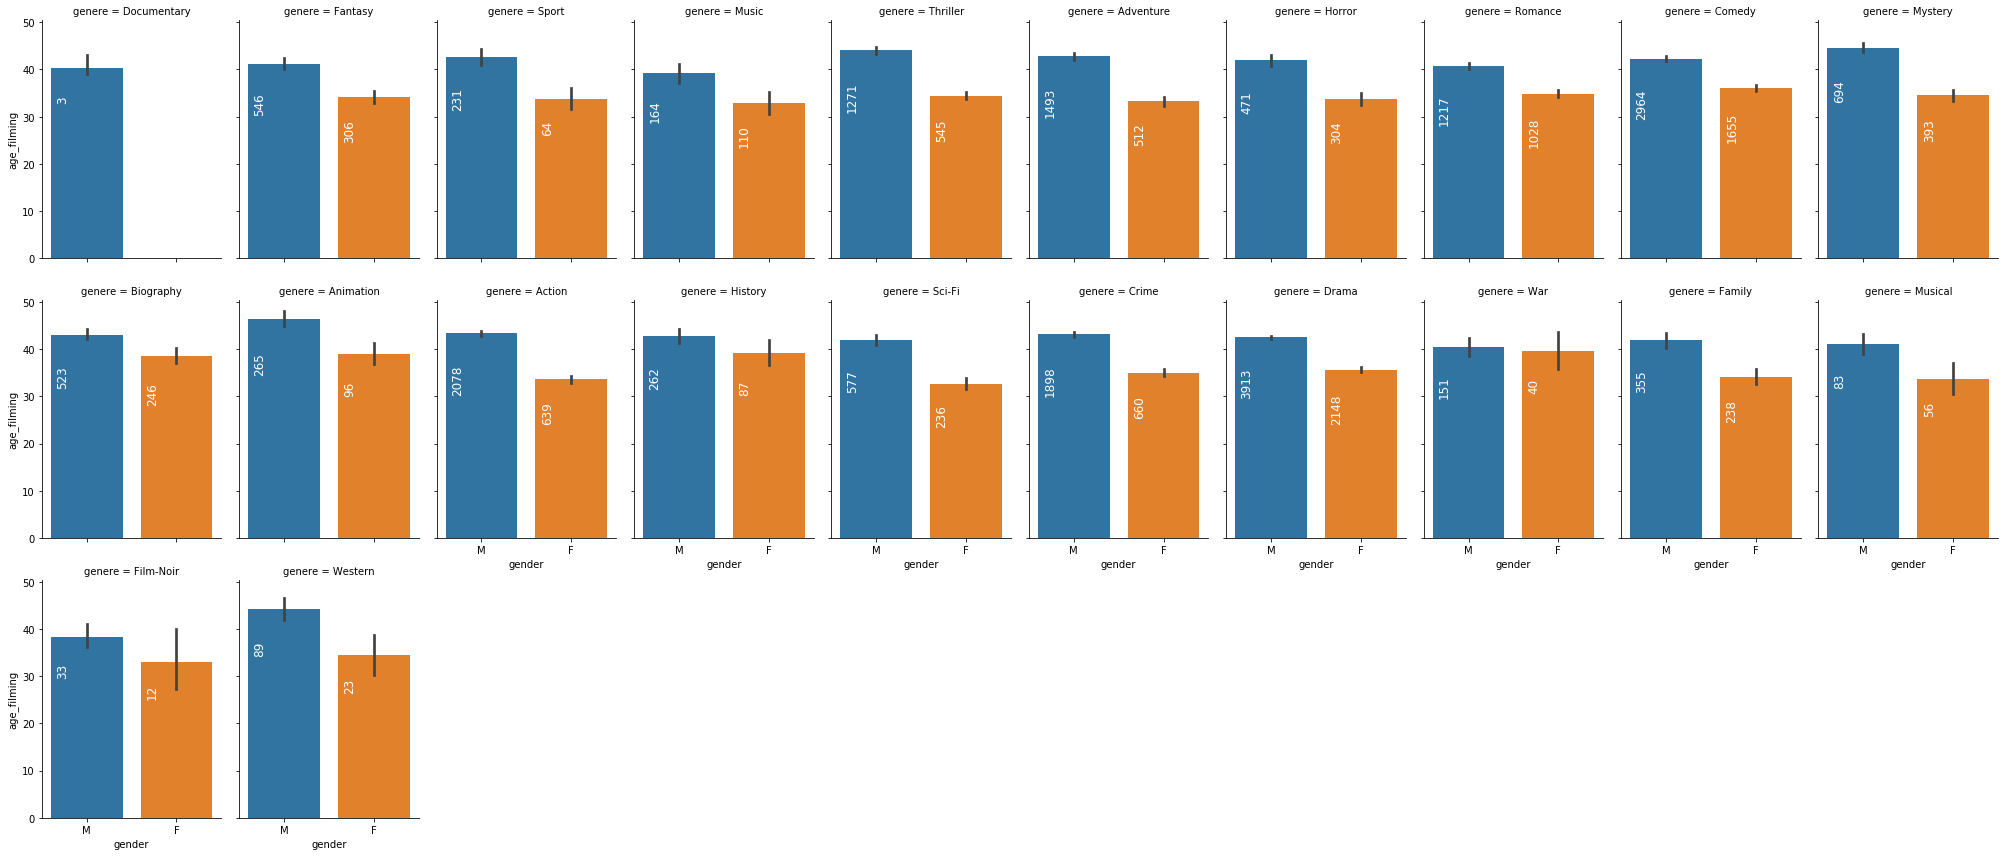

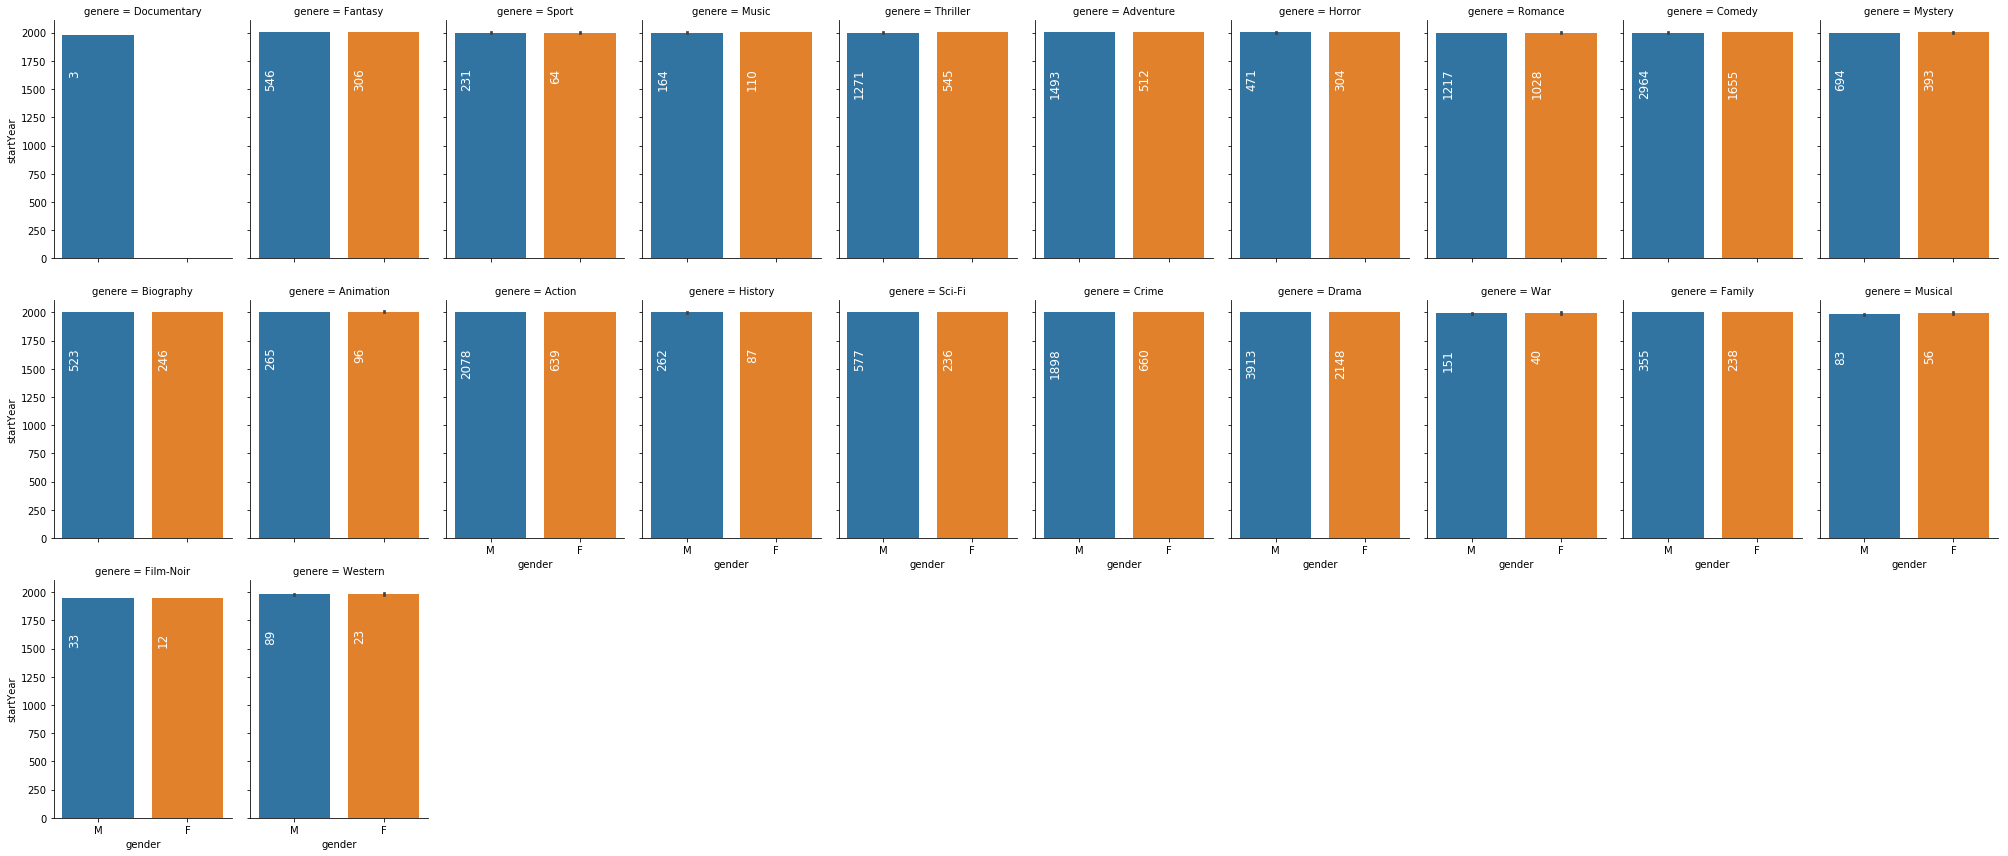

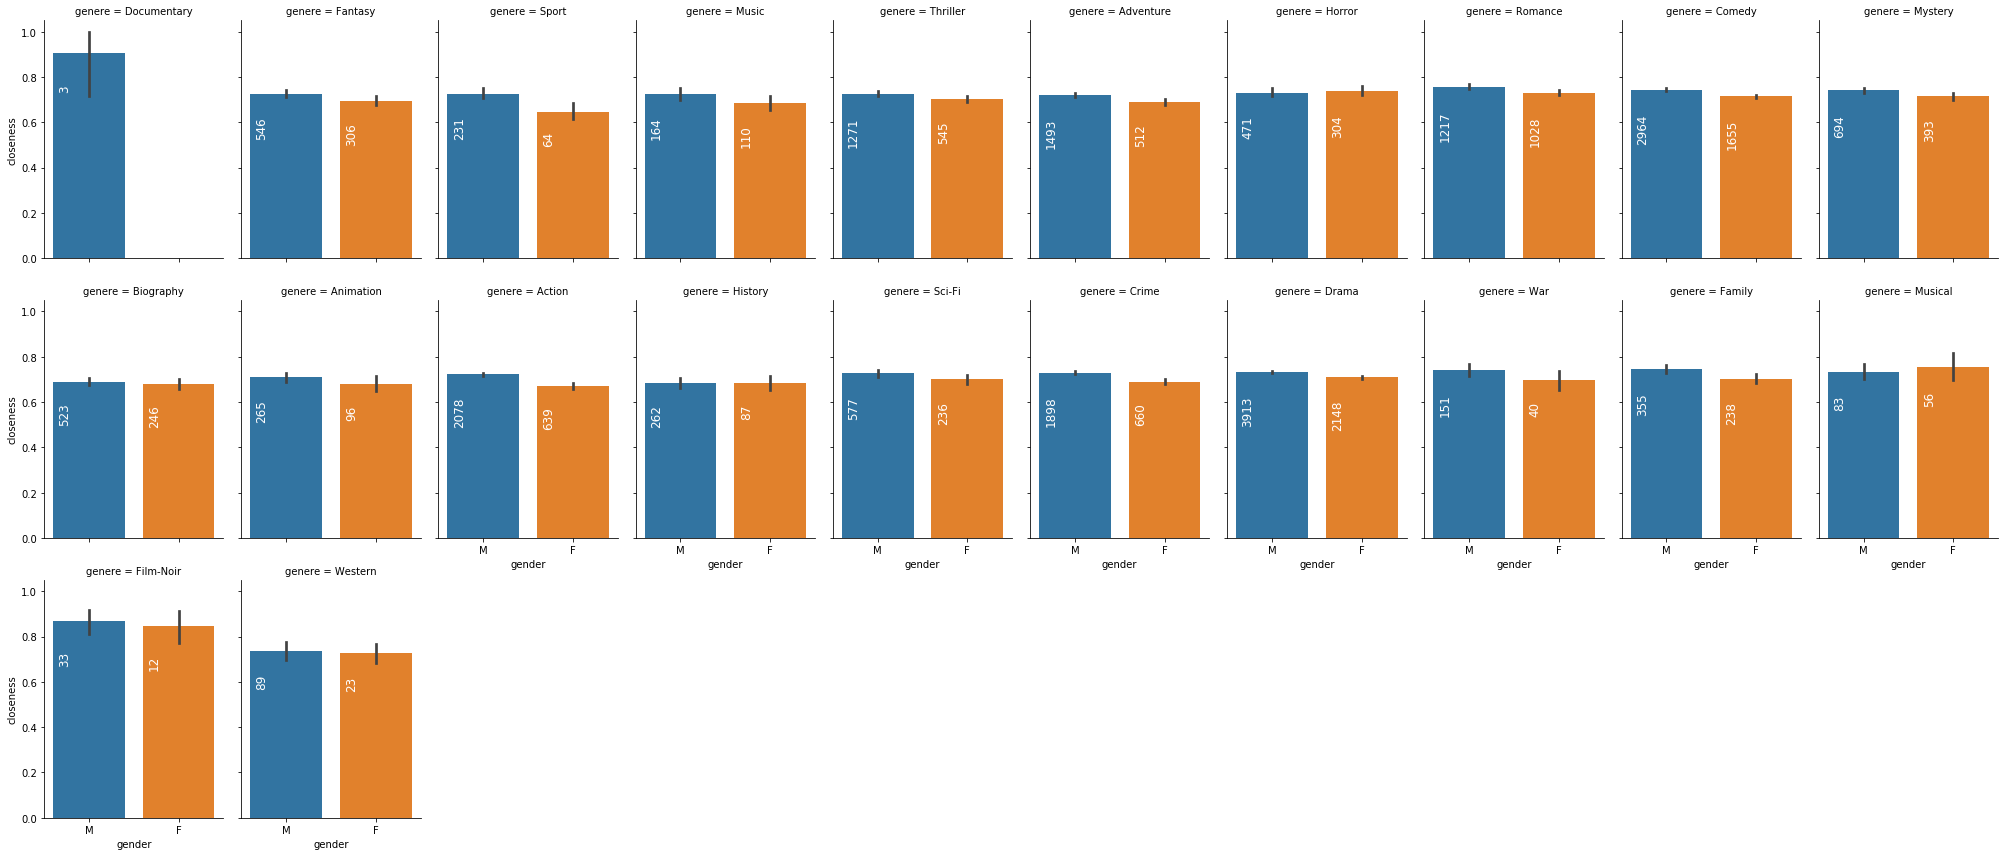

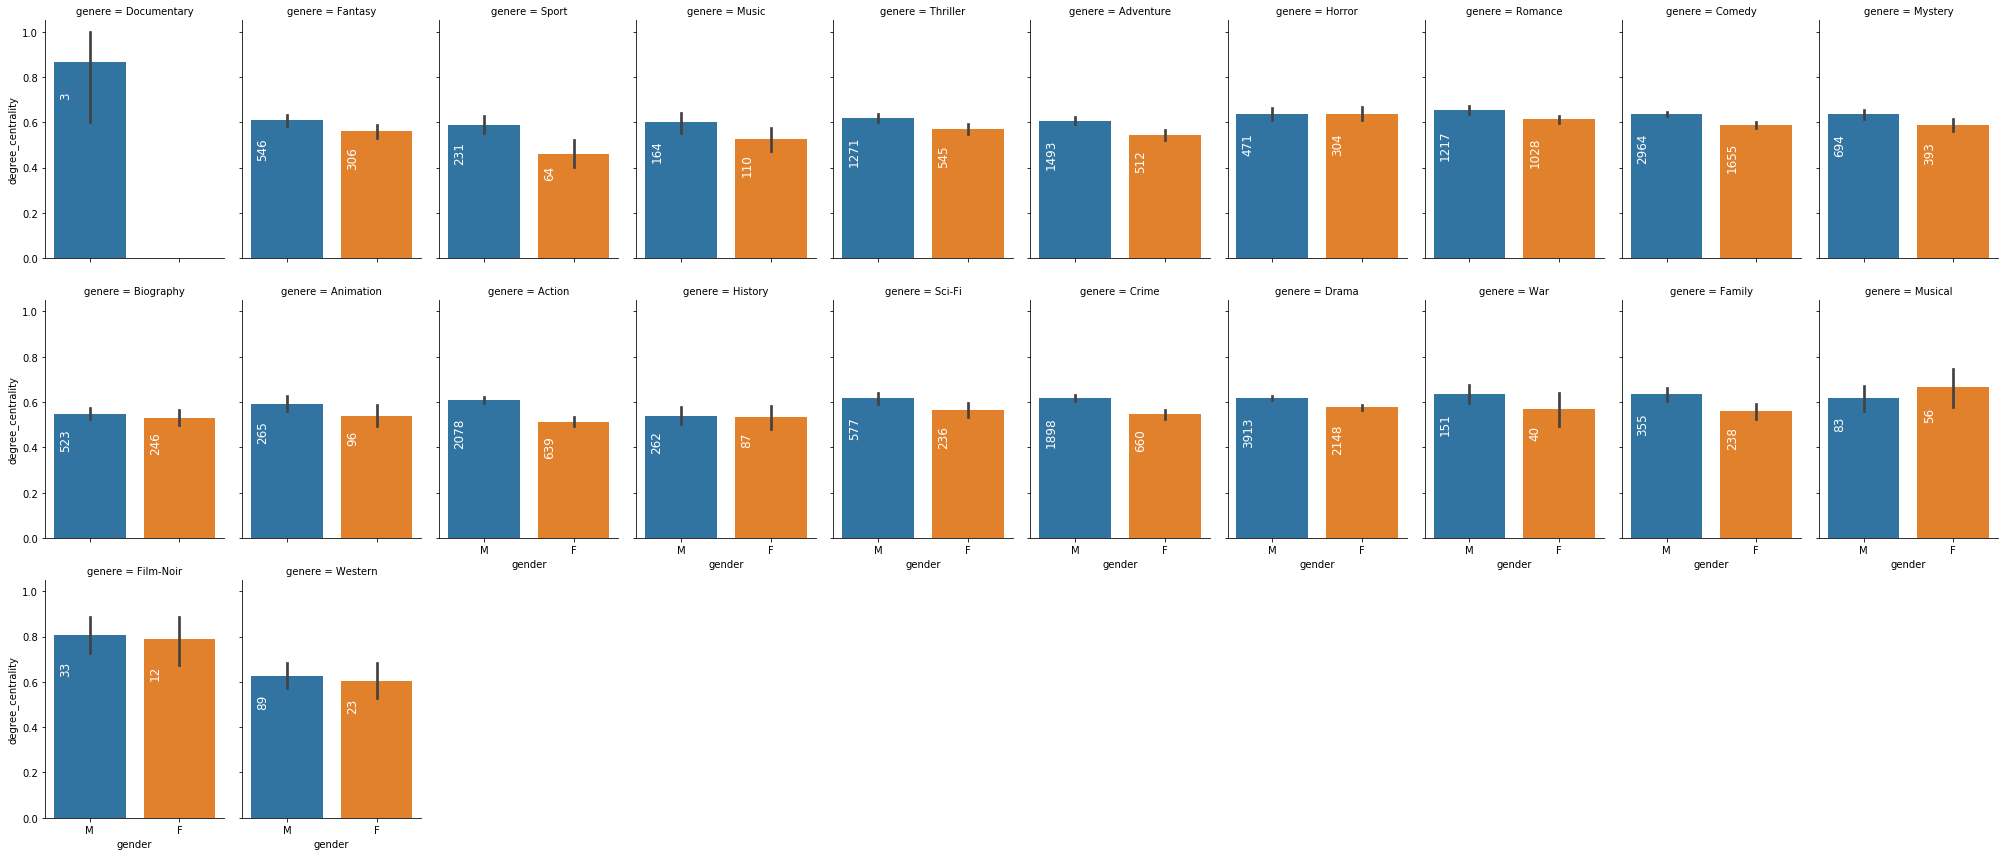

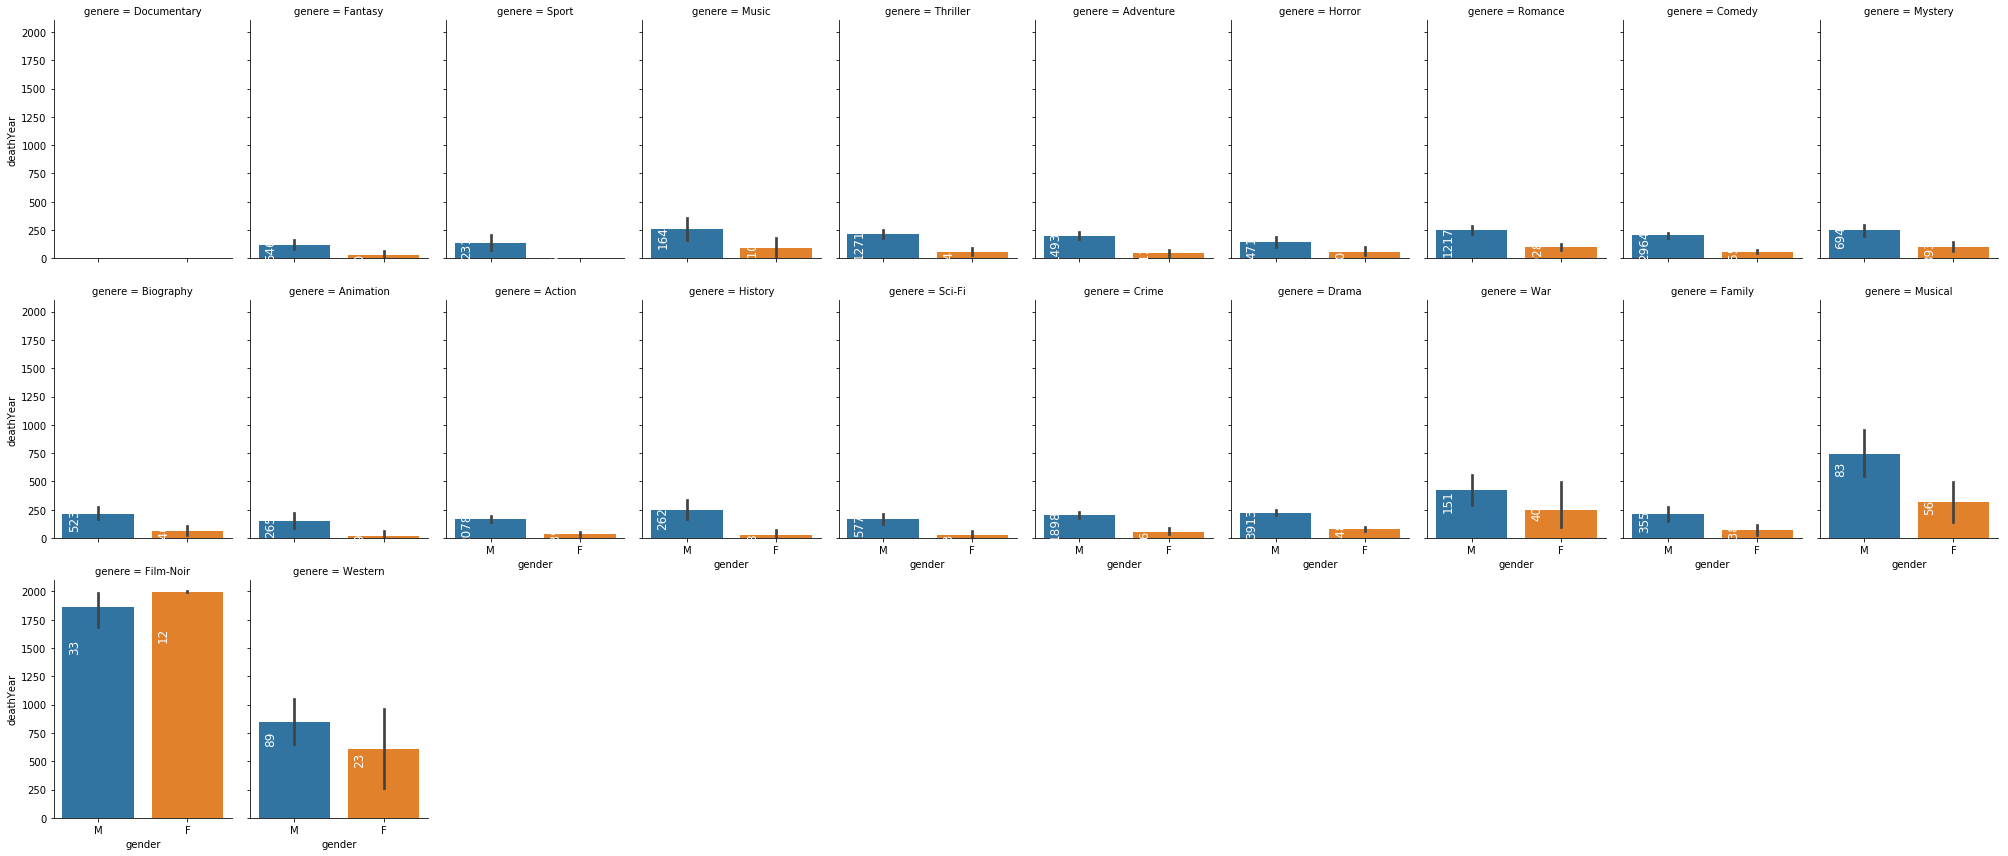

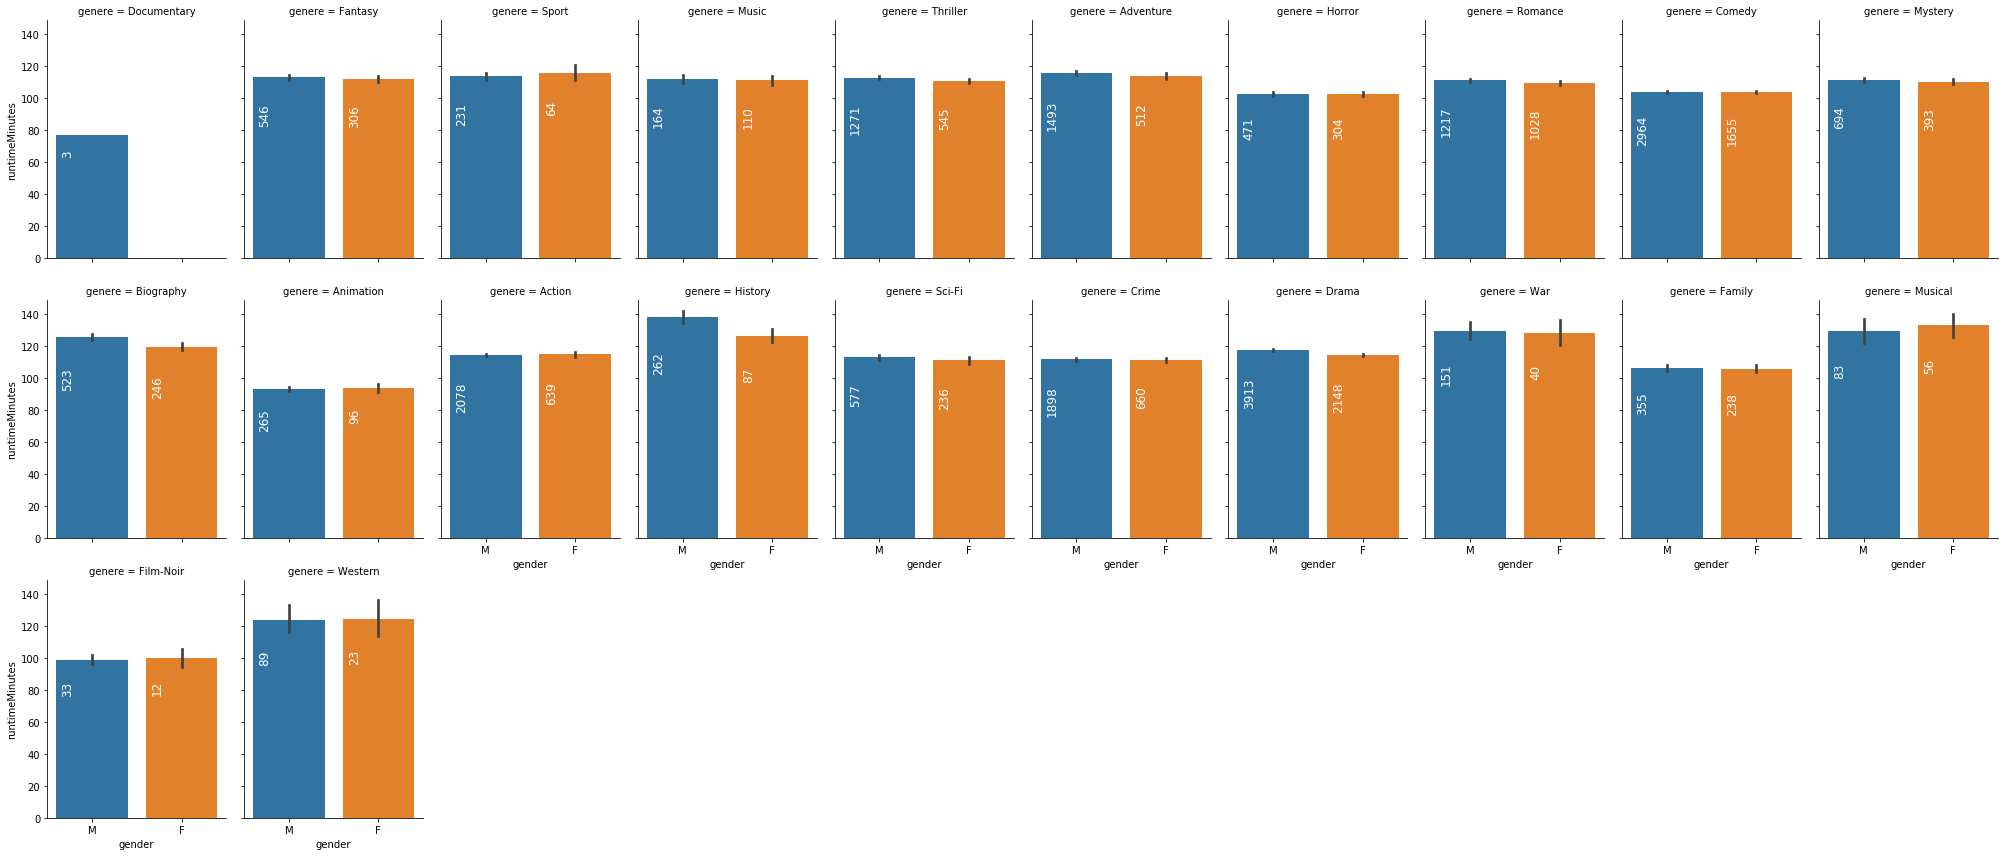

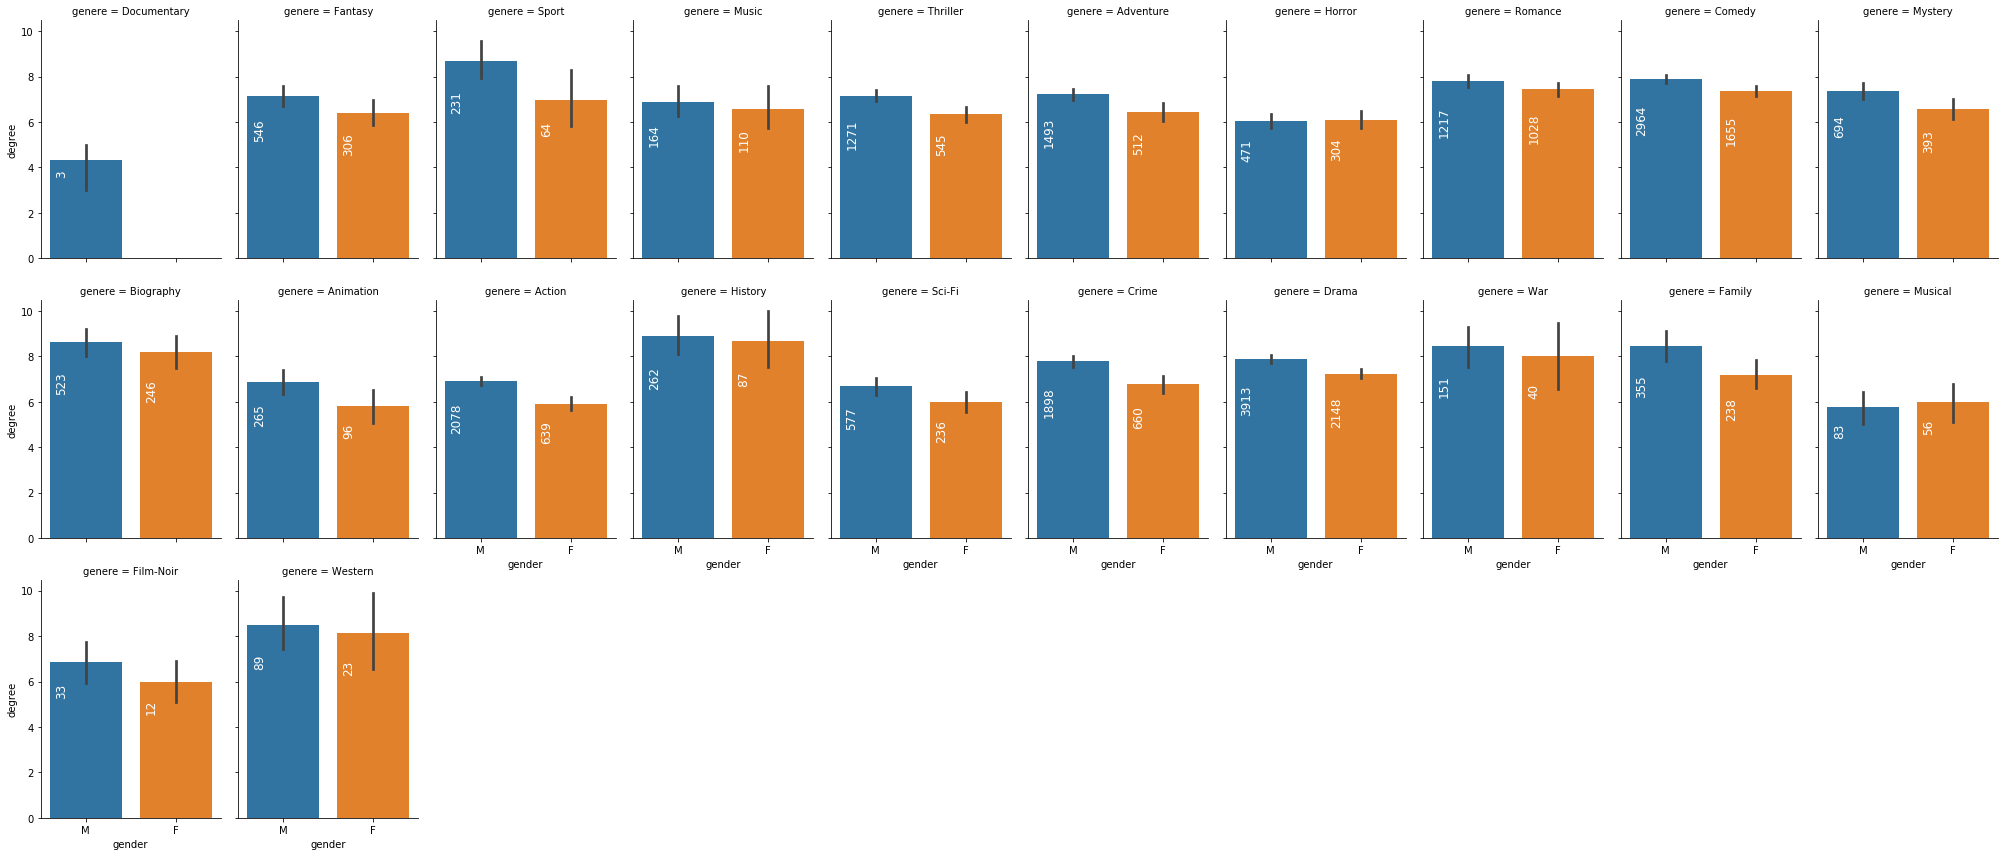

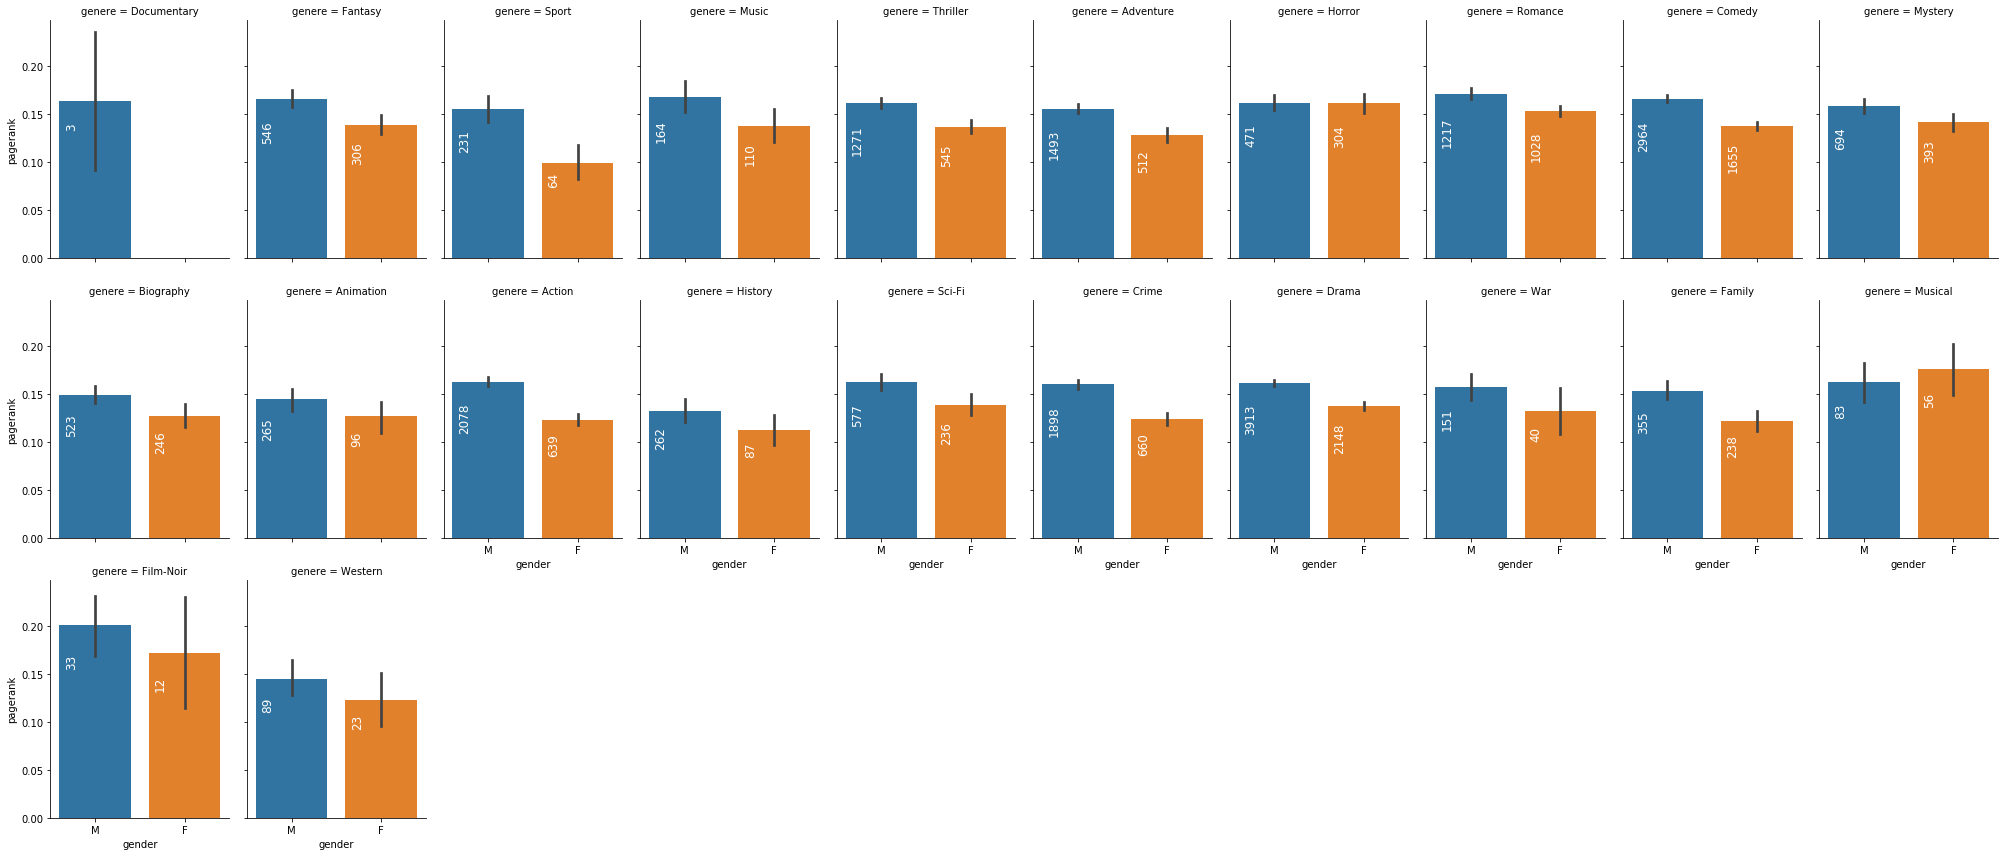

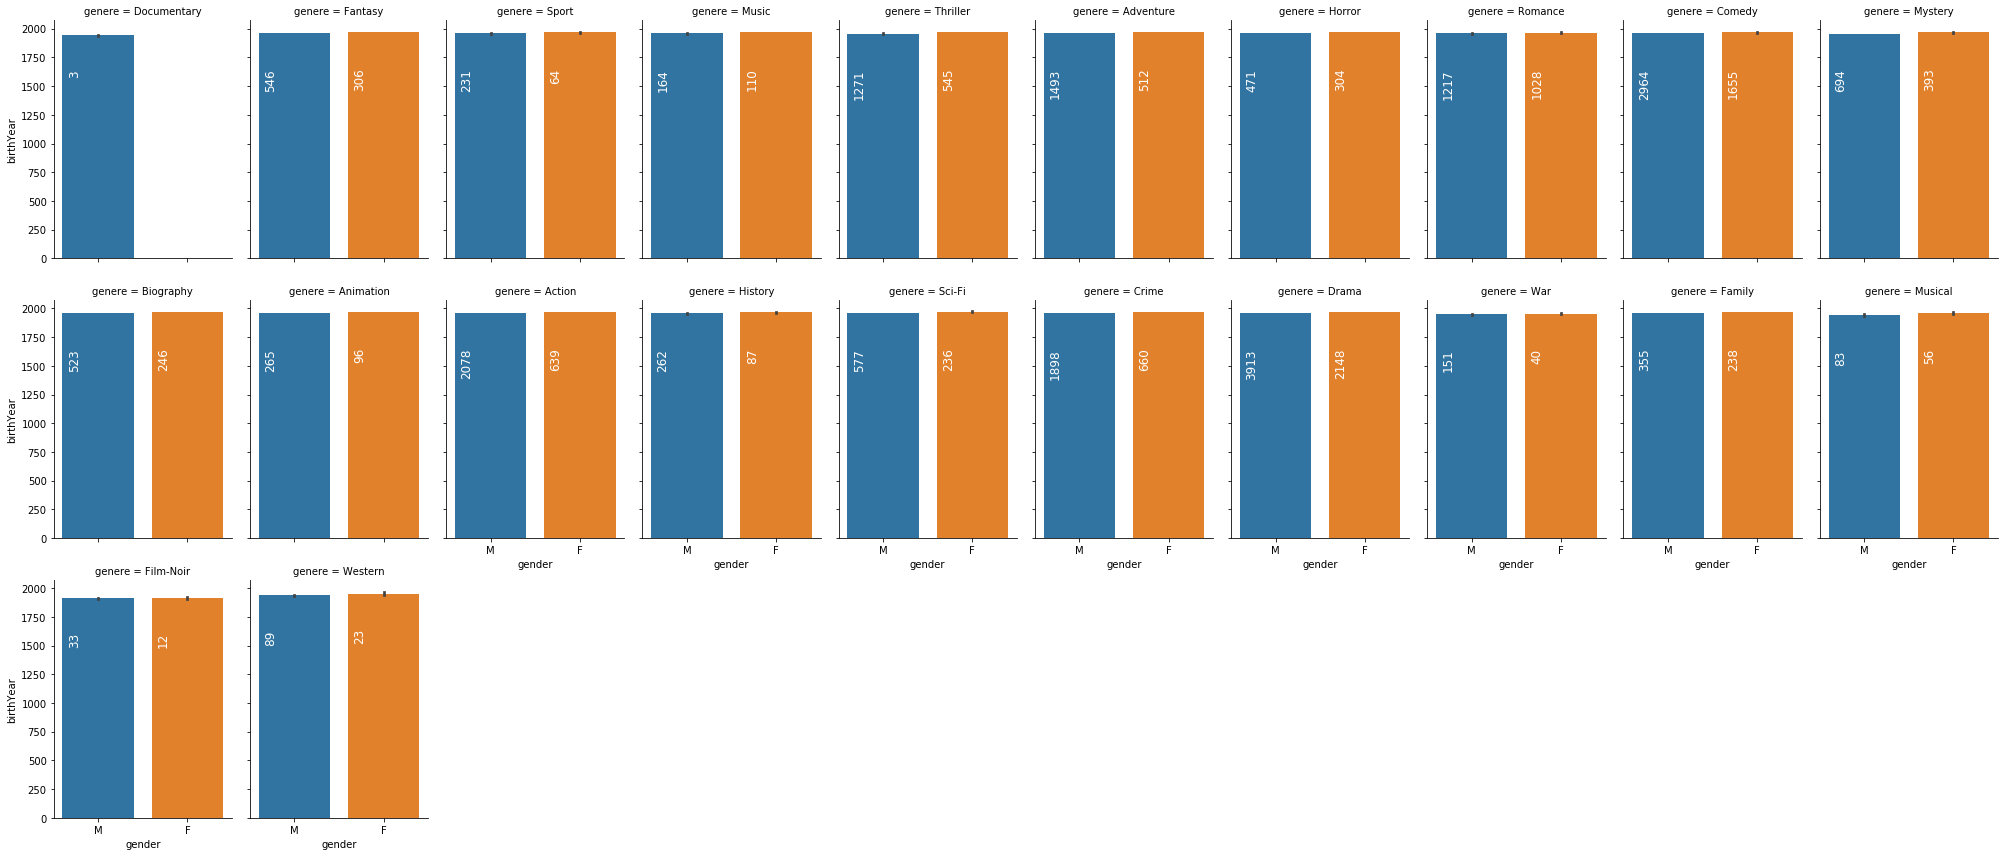

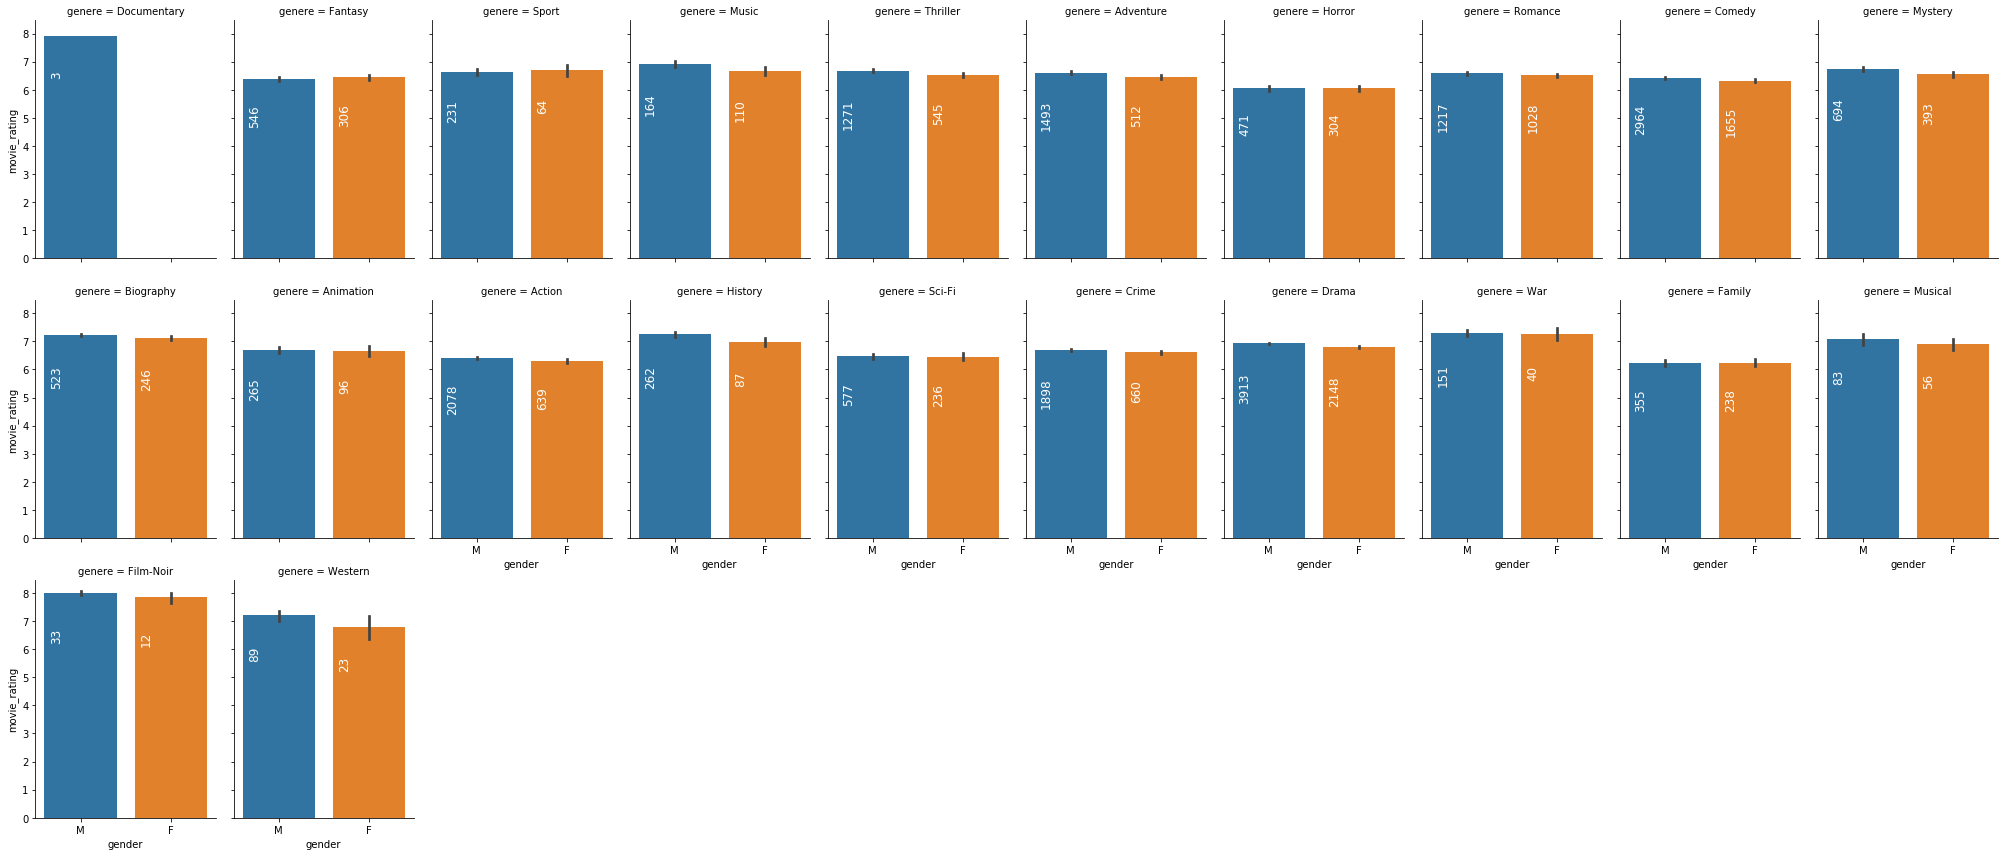

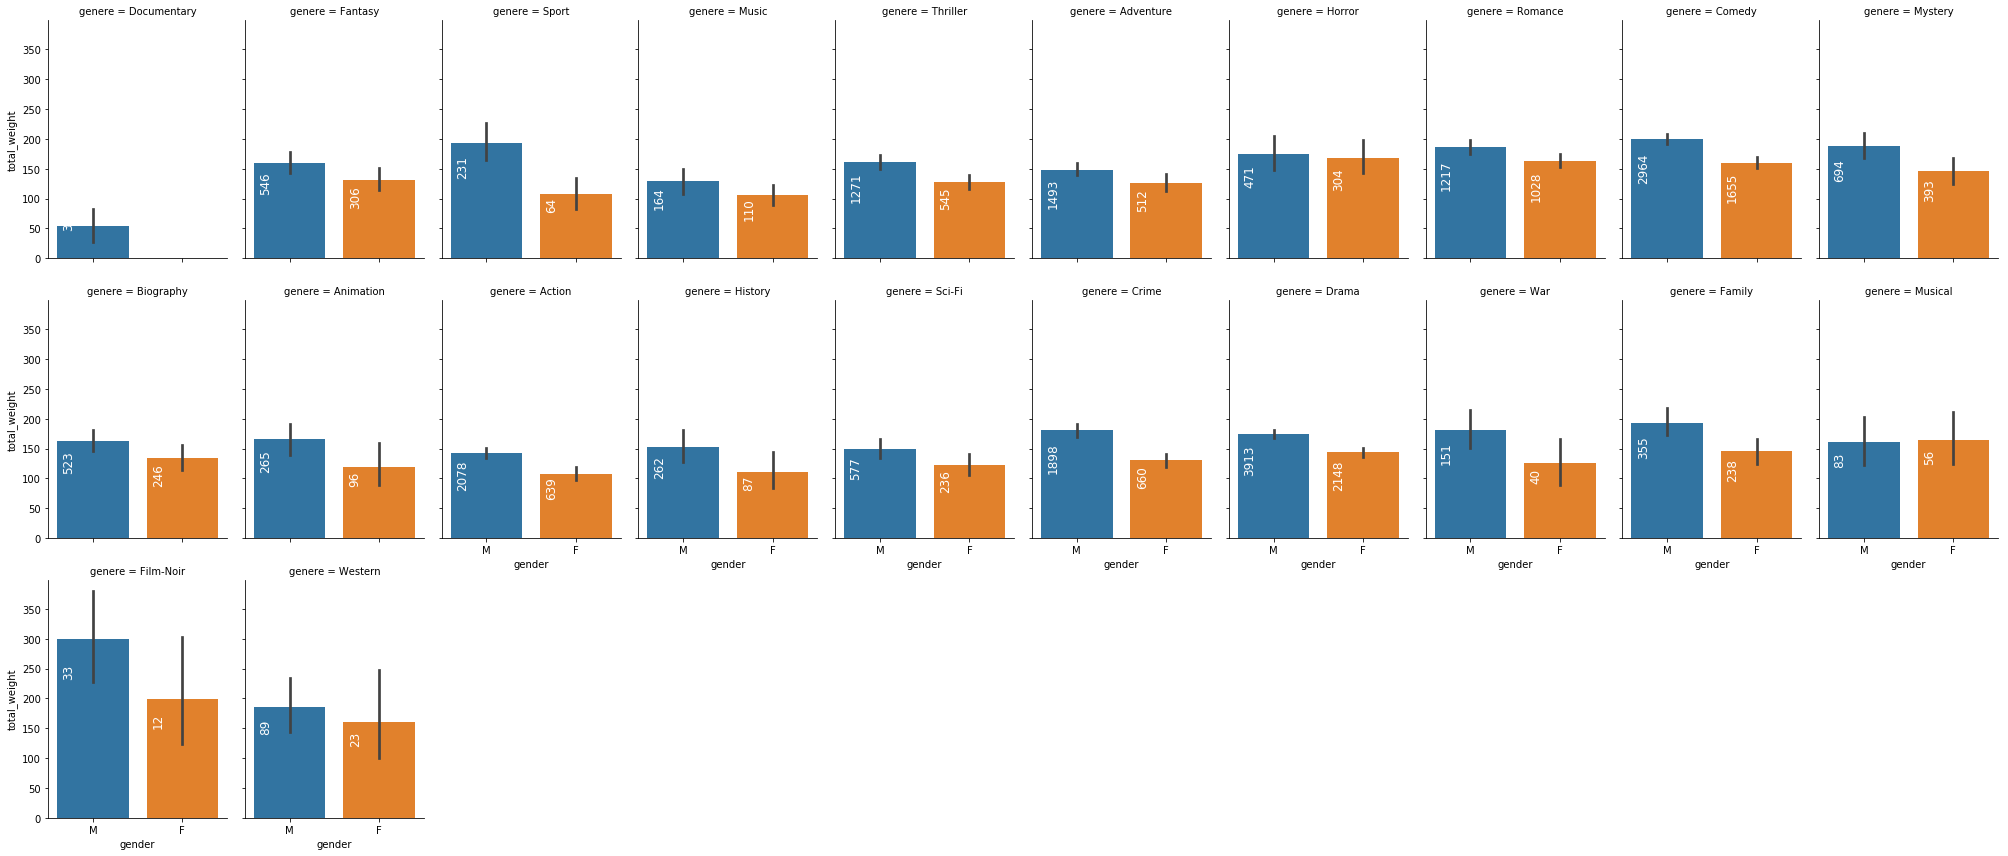

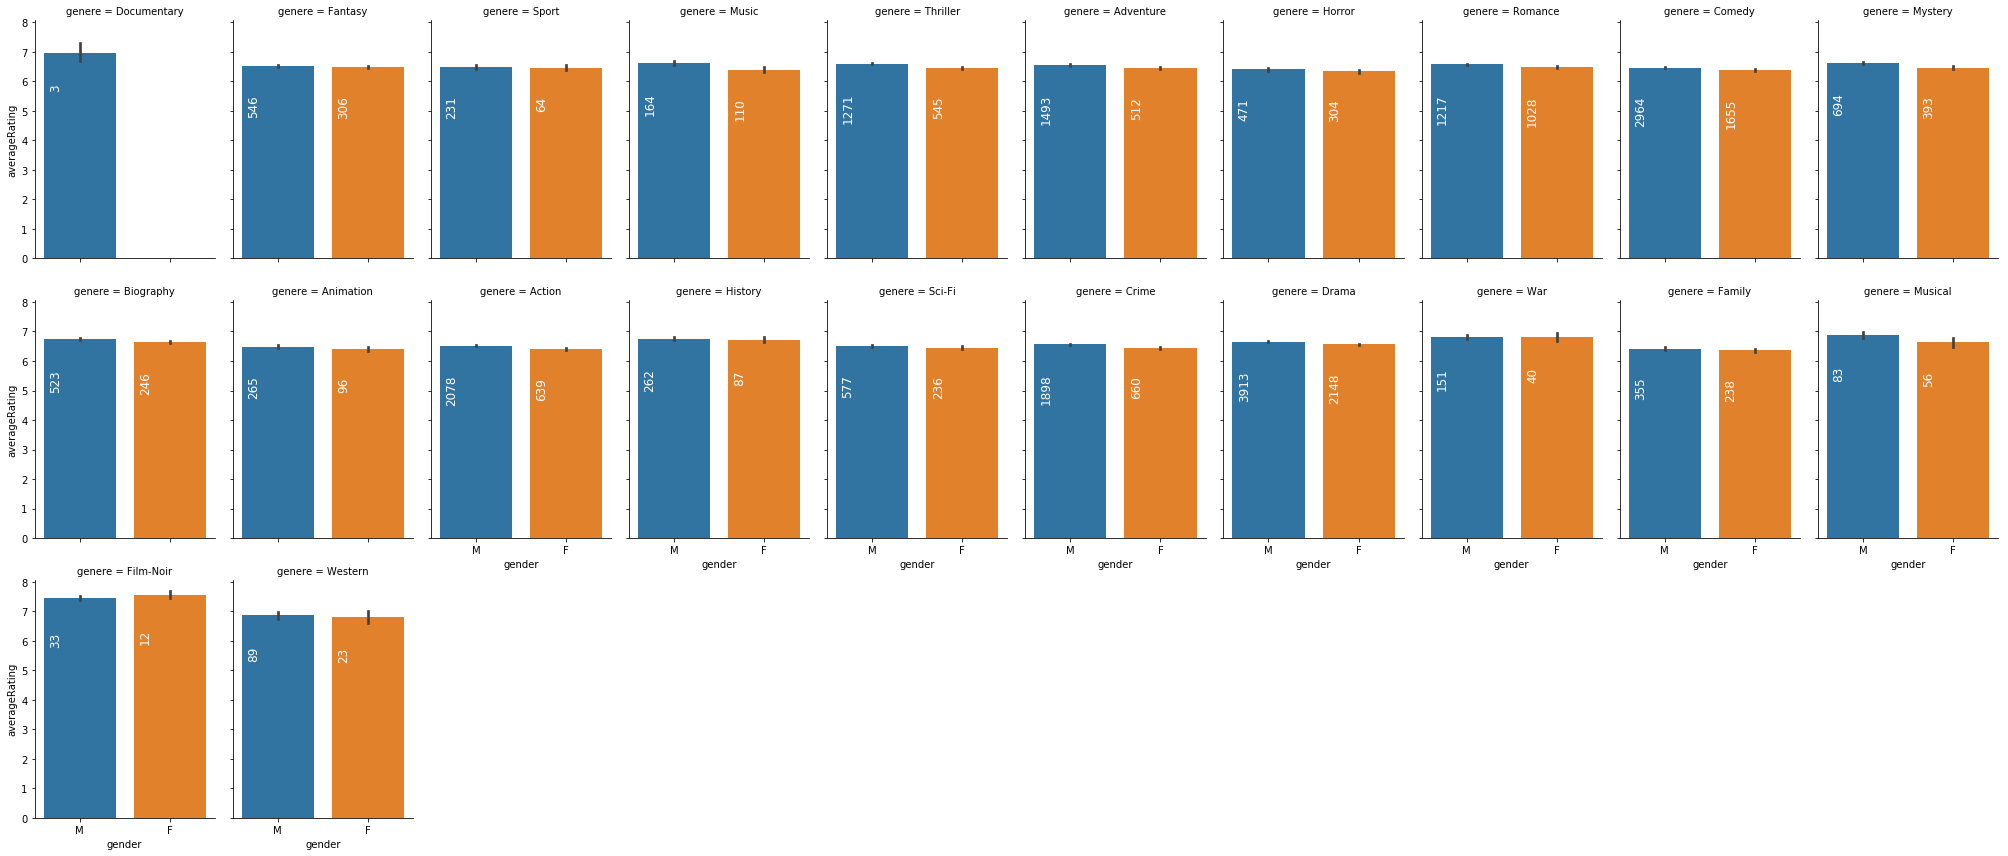

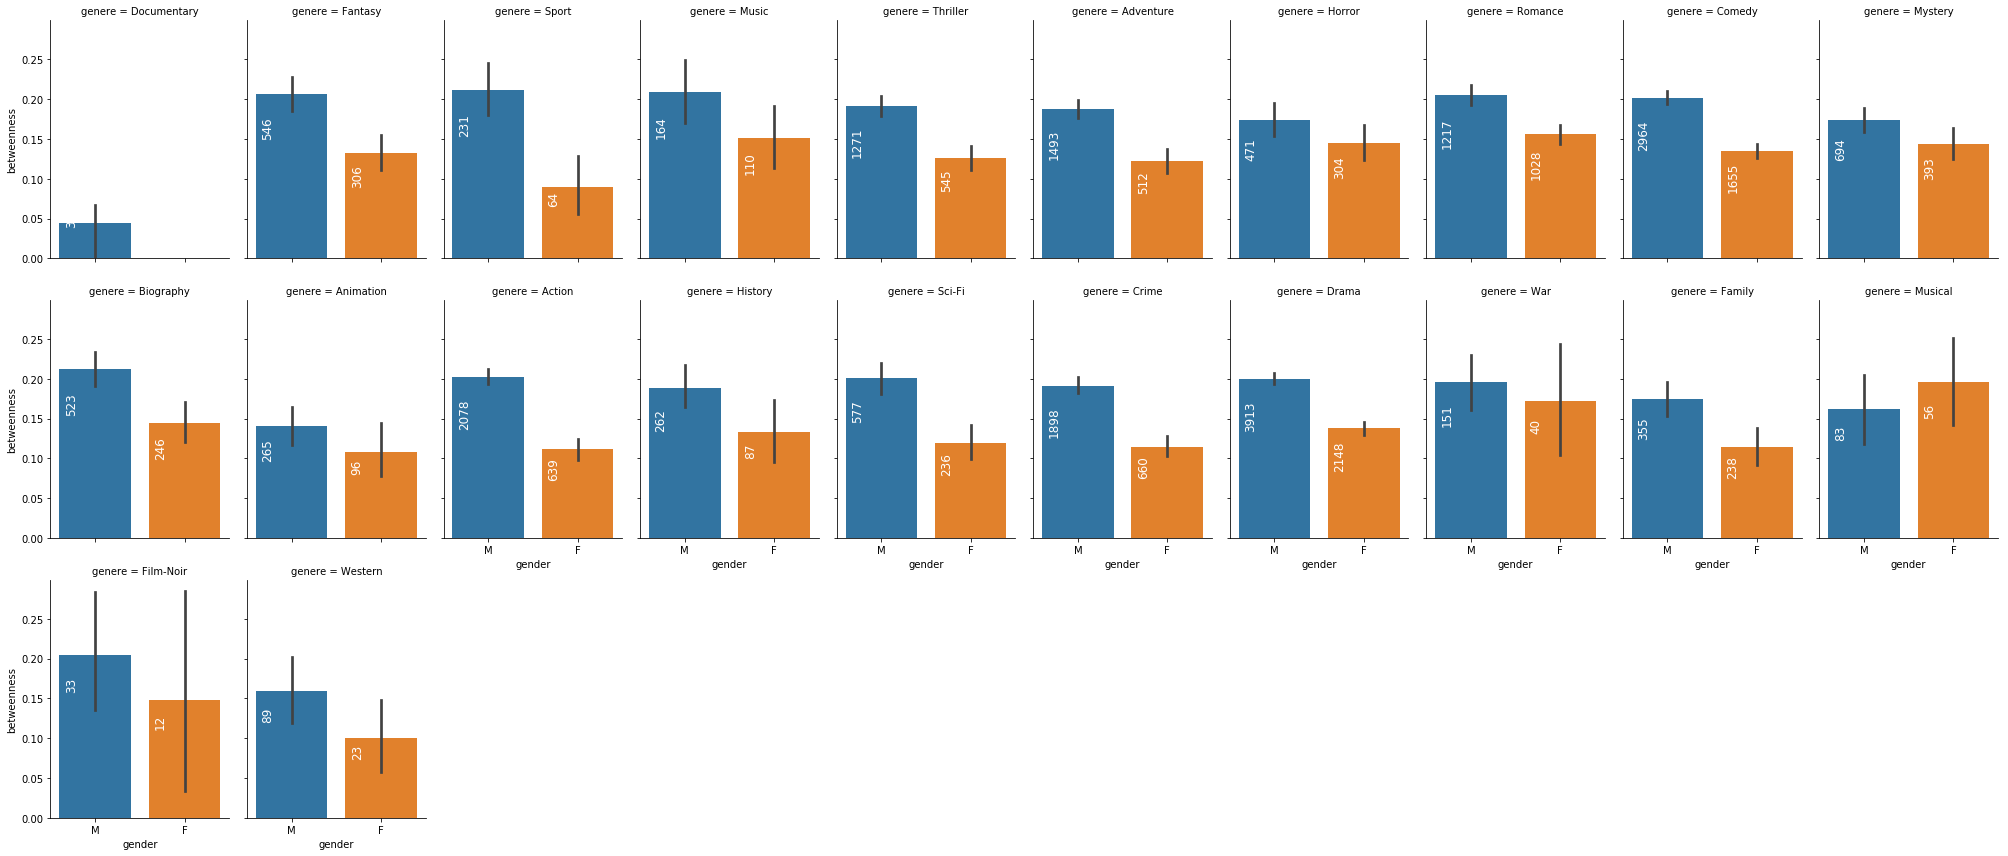

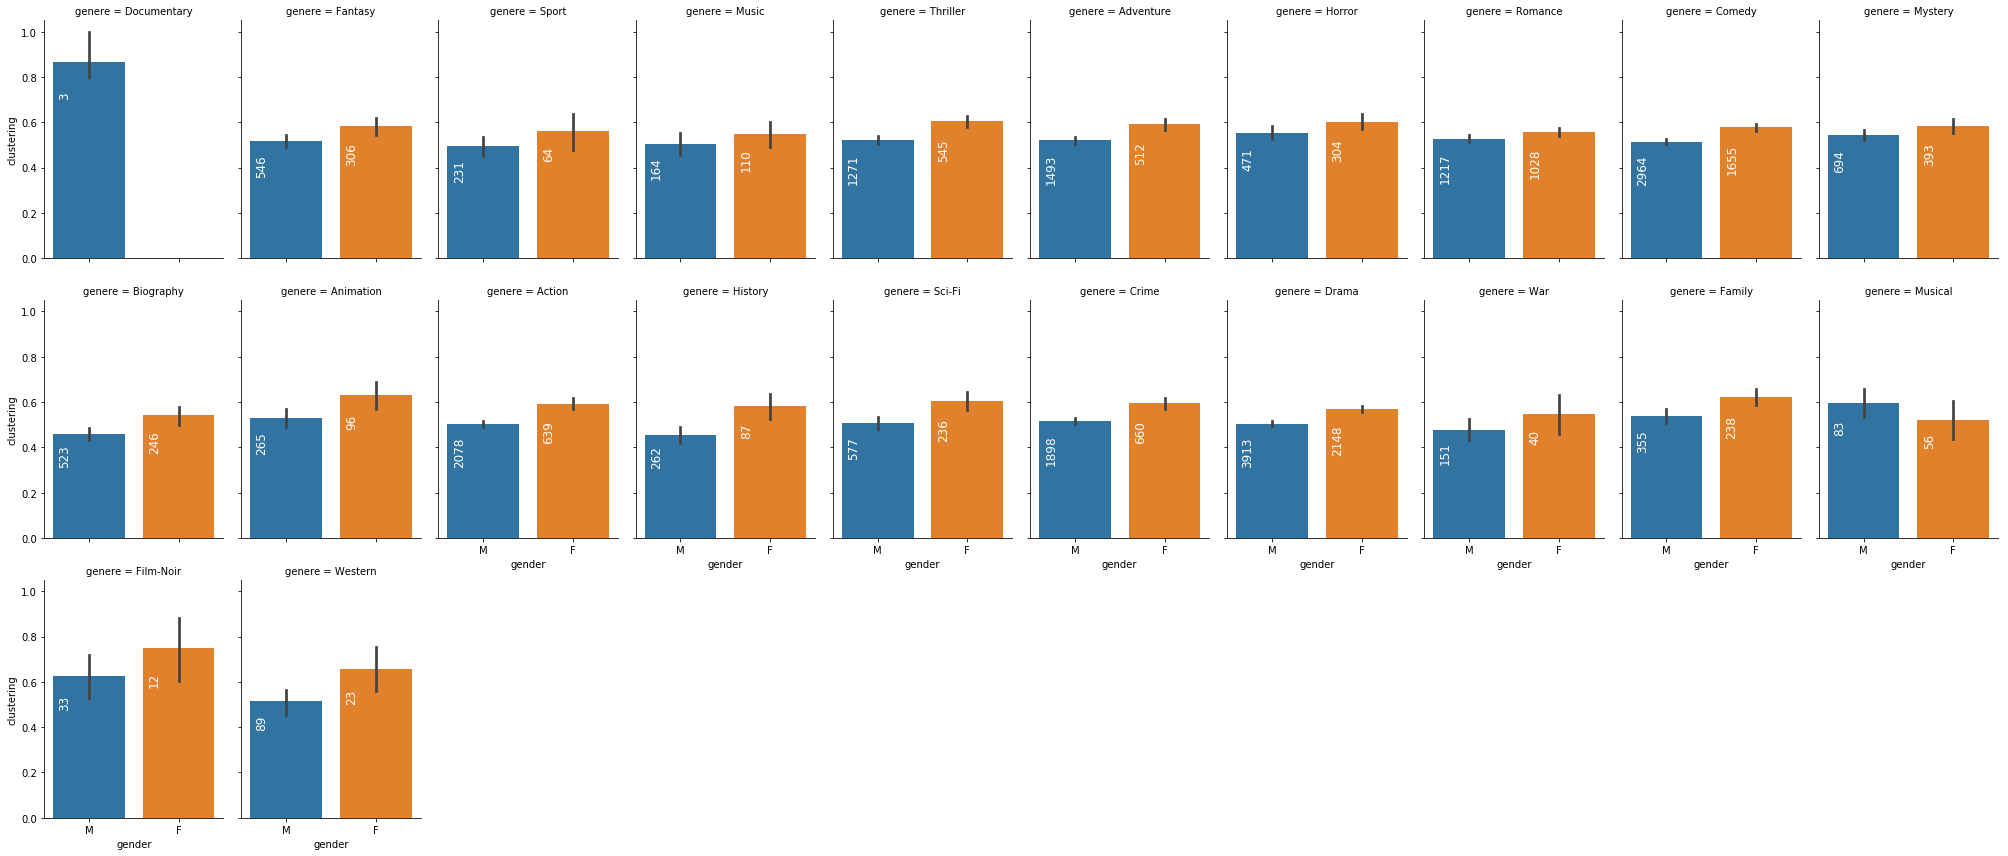

In [81]:
import seaborn as sns
bins = ["M", "F"]

for feature in id_vars:
    if feature != "gender":
        g = sns.catplot(x="gender", y=feature, col="genere",
                         data=df_chart, kind="bar", col_wrap=10,
                         height=4, aspect=.7);
        for i in np.arange(22):
        #     for j in np.arange(4):
                ax1 = g.facet_axis(0,i)
                plot_genere = ax1.title._text.split(" = ")[1]
                for i, p in enumerate(ax1.patches):
                    if str(p.get_height()) != 'nan':
                        ax1.text(p.get_x() + 0.06, p.get_height() * .8, ((df_chart["genere"]==plot_genere) & (df_chart["gender"]==bins[i])).sum(), color='white', rotation='vertical', size='large')

        g.savefig(f"features/{feature}.png")

#### Triangles

In [8]:
from turicreate import SFrame

In [1942]:
from subs2graph.bechdel_classifier import get_relationship_triangles, count_triangles

In [ ]:
triangles_gender_bin = get_relationship_triangles()

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/triangles.csv

Parsing completed. Parsed 100 lines in 0.370205 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/triangles.csv

Parsing completed. Parsed 437671 lines in 0.377624 secs.

In [1990]:
t = count_triangles()

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/triangles.csv

Parsing completed. Parsed 100 lines in 0.384861 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/triangles.csv

Parsing completed. Parsed 437671 lines in 0.370036 secs.

In [1992]:
t

Males in triangle,0,1,2,3,total
Action,0.018178,0.137599,0.396688,0.447535,66730
Adventure,0.017145,0.150020,0.411956,0.420880,63985
Animation,0.039844,0.209039,0.432849,0.318268,24847
Biography,0.025428,0.140601,0.356441,0.477530,37361
Comedy,0.043078,0.216539,0.418341,0.322042,271300
Crime,0.024309,0.158558,0.414011,0.403123,82109
Documentary,0.044631,0.196741,0.396301,0.362327,61370
Drama,0.046091,0.220767,0.402572,0.330569,278099
Family,0.050274,0.217846,0.411865,0.320015,37017
Fantasy,0.040478,0.207679,0.413942,0.337901,26854


In [1932]:
piv_test = triagles_gender_bin.groupby(["year","sum"], operations={'count': agg.COUNT()})

In [1933]:
piv_test["decade"] = piv_test["year"]//10

In [1935]:
piv_test = pd.pivot_table(piv_test.to_dataframe()[["decade","sum","count"]],index="decade", columns="sum", values="count", fill_value=0, aggfunc=np.sum)

In [1936]:
piv_test

sum,0,1,2,3
decade,,,,
192,1,14,28,9
193,140,1104,2565,2034
194,381,2412,4863,3317
195,279,2007,5428,5194
196,271,1883,4899,5370
197,554,2890,6243,6752
198,1026,5944,11990,9522
199,2773,14677,30557,28142
200,6864,31029,58158,46855


In [1937]:
piv_test["total"] = piv_test[0]+piv_test[1]+ piv_test[2]+ piv_test[3]
for i in range(4):
    piv_test[i] = piv_test[i]/piv_test["total"]

In [1938]:
piv_test

sum,0,1,2,3,total
decade,,,,,
192,0.019231,0.269231,0.538462,0.173077,52
193,0.023960,0.188944,0.438987,0.348109,5843
194,0.034722,0.219812,0.443179,0.302287,10973
195,0.021615,0.155485,0.420514,0.402386,12908
196,0.021814,0.151574,0.394349,0.432263,12423
197,0.033700,0.175801,0.379768,0.410731,16439
198,0.036023,0.208693,0.420968,0.334316,28482
199,0.036415,0.192741,0.401279,0.369565,76149
200,0.048032,0.217129,0.406967,0.327873,142906


In [1859]:
piv_test

sum,0,1,2,3,total
year,,,,,
1920,0.000000,0.217391,0.565217,0.217391,23
1922,0.000000,0.000000,0.500000,0.500000,2
1924,0.000000,0.000000,0.750000,0.250000,4
1929,0.043478,0.391304,0.478261,0.086957,23
1930,0.000000,0.102564,0.376068,0.521368,117
1931,0.006024,0.054217,0.427711,0.512048,166
1932,0.008333,0.195833,0.516667,0.279167,240
1933,0.040146,0.257299,0.343066,0.359489,548
1934,0.019608,0.250545,0.509804,0.220044,459


In [1847]:
triagles_gender_bin.groupby(["year","sum"], operations={'count': agg.COUNT()}).sort(["year","sum"]).unstack(["year","count"], new_column_name='c').unpack("c").to_dataframe().T

,0,1,2,3
sum,2.0,3.0,0.0,1.0
c.1920,13.0,5.0,NaN,5.0
c.1922,1.0,1.0,NaN,NaN
c.1924,3.0,1.0,NaN,NaN
c.1929,11.0,2.0,1.0,9.0
c.1930,44.0,61.0,NaN,12.0
c.1931,71.0,85.0,1.0,9.0
c.1932,124.0,67.0,2.0,47.0
c.1933,188.0,197.0,22.0,141.0
c.1934,234.0,101.0,9.0,115.0


In [1776]:
triagles_gender_bin["genres"] =triagles_gender["genres"].apply(lambda x: x.split(","))

In [1777]:
triagles_gender_bin = triagles_gender_bin.unpack("genres")



In [1778]:
triagles_gender_bin.save(f"../temp/gender_tri.csv", format="csv")

In [1779]:
triagles_gender_bin = SFrame.read_csv(f"../temp/gender_tri.csv")

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/gender_tri.csv

Parsing completed. Parsed 100 lines in 0.300751 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,int,int,str,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/gender_tri.csv

Parsing completed. Parsed 718961 lines in 0.395449 secs.

In [1780]:
triagles_gender_bin = triagles_gender_bin.pack_columns(column_name_prefix="genres")

In [1782]:
triangles_df = triagles_gender_bin.to_dataframe()

In [1784]:
for genre in set().union(*triangles_df.genres.values):
    triangles_df[genre] = triangles_df.apply(lambda _: int(genre in _.genres), axis=1)

In [1787]:
triangles_df2 = triangles_df.drop(["1","2","3","genres"],axis=1)

In [1788]:
triangles_df2 = triangles_df2.rename(columns={"sum":"Males in triangle"})

In [ ]:
triangles_df2["decade"] = triangles_df2["year"]//10

In [ ]:
temp = triangles_df2.pop("year")

In [1921]:
temp = pd.melt(triangles_df2, id_vars=['decade',"Males in triangle"], value_vars=genres) 

In [1922]:
temp  = temp[temp["value"]!=0]

In [1923]:
temp = pd.pivot_table(temp,columns="Males in triangle", index=[ "variable", "decade"], aggfunc=np.sum, fill_value=0)

In [1924]:
temp = temp["value"]

In [1925]:
temp["total"] = temp[0]+temp[1]+ temp[2]+ temp[3]
for i in range(4):
    temp[i] = temp[i]/temp["total"]

In [1926]:
temp

Males in triangle         0         1         2         3  total
variable  decade                                                
Action    193      0.000000  0.041237  0.298969  0.659794    194
          194      0.006218  0.061140  0.332642  0.600000    965
          195      0.003851  0.064185  0.437741  0.494223    779
          196      0.003665  0.072083  0.304215  0.620037   1637
          197      0.005131  0.073228  0.311101  0.610541   2144
          198      0.011289  0.083725  0.357165  0.547821   3189
          199      0.007123  0.114880  0.411692  0.466305   8844
          200      0.016897  0.131295  0.387816  0.463991  18287
          201      0.025317  0.166140  0.413346  0.395197  30691
Adventure 192      0.000000  0.000000  0.750000  0.250000      4
          193      0.011765  0.105882  0.370588  0.511765    510
          194      0.015287  0.133758  0.424204  0.426752    785
          195      0.002852  0.071768  0.402567  0.522814   2104
          196      0.012937  0.106727  0.309185  0.571151   1546
          197      0.010850  0.124774  0.395419  0.468957   1659
          198      0.023077  0.169231  0.388846  0.418846   2600
          199      0.010889  0.134613  0.403566  0.450932   7347
          200      0.017523  0.140321  0.418592  0.423565  21515
          201      0.019950  0.172063  0.419332  0.388655  25915
Animation 194      0.000000  0.062992  0.535433  0.401575    127
          196      0.009524  0.190476  0.447619  0.352381    105
          197      0.015564  0.155642  0.346304  0.482490    257
          198      0.039724  0.295337  0.414508  0.250432    579
          199      0.014747  0.200140  0.457865  0.327247   1424
          200      0.056172  0.258243  0.464546  0.221039   6854
          201      0.033095  0.185923  0.420295  0.360686  15501
Biography 193      0.012579  0.128931  0.424528  0.433962    318
          194      0.002247  0.076404  0.438202  0.483146    445
          195      0.003480  0.087007  0.383991  0.525522    862
          196      0.010638  0.125000  0.390957  0.473404    376
...                     ...       ...       ...       ...    ...
Sport     199      0.002953  0.042528  0.320732  0.633786   1693
          200      0.045045  0.086052  0.281454  0.587450   3219
          201      0.017046  0.089233  0.297791  0.595930   5749
Thriller  193      0.059829  0.188034  0.461538  0.290598    117
          194      0.025145  0.228240  0.502901  0.243714    517
          195      0.010989  0.175824  0.505495  0.307692    364
          196      0.013730  0.143021  0.405034  0.438215    874
          197      0.033486  0.155046  0.420183  0.391284   2180
          198      0.024867  0.160309  0.436021  0.378803   4142
          199      0.024655  0.145085  0.397851  0.432410   9491
          200      0.034918  0.175984  0.389116  0.399981  10768
          201      0.033210  0.206901  0.444465  0.315424  21590
War       193      0.000000  0.054945  0.208791  0.736264     91
          194      0.021169  0.127016  0.295363  0.556452    992
          195      0.005005  0.057057  0.264264  0.673674    999
          196      0.006567  0.063881  0.210746  0.718806   1675
          197      0.006548  0.042095  0.198316  0.753040   1069
          198      0.022059  0.151961  0.323529  0.502451    816
          199      0.018045  0.111278  0.196992  0.673684   1330
          200      0.022129  0.166866  0.399522  0.411483   1672
          201      0.026234  0.146783  0.295440  0.531543   1601
Western   193      0.000000  0.013100  0.291121  0.695779    687
          194      0.009023  0.108271  0.457143  0.425564    665
          195      0.006536  0.090777  0.403776  0.498911   1377
          196      0.003688  0.071923  0.363301  0.561088   2169
          197      0.010961  0.070826  0.244519  0.673693   1186
          198      0.000000  0.057508  0.207668  0.734824    313
          199      0.020134  0.158389  0.303356  0.518121    745
          200      0.006356  0.0953

In [60]:
piv["total"] = piv[0]+piv[1]+ piv[2]+ piv[3]

In [61]:
for i in range(4):
    piv[i] = piv[i]/piv["total"]

In [ ]:
gen

In [62]:
piv

Males in triangle,0,1,2,3,total
Action,0.025245,0.161778,0.417657,0.395319,34739
Adventure,0.020401,0.165932,0.421246,0.392422,32646
Animation,0.039756,0.220759,0.430963,0.308522,12602
Biography,0.029842,0.143943,0.365802,0.460412,21446
Comedy,0.051136,0.232704,0.415755,0.300405,151772
Crime,0.027698,0.171888,0.426939,0.373475,42964
Documentary,0.056211,0.210582,0.401132,0.332076,36043
Drama,0.053189,0.233169,0.405896,0.307746,155089
Family,0.050479,0.214075,0.402779,0.332667,18998
Fantasy,0.035223,0.204467,0.417057,0.343252,12804


#### Centrality

In [63]:
from itertools import islice
gender_top_movies = islice(gender_in_top_movies(), 1000)

In [64]:
gender_top_movies = list(gender_top_movies)

 12%|█▏        | 1394/11343 [02:13<22:55,  7.23it/s] 

In [65]:
import itertools
gender_top_100 = list(itertools.chain.from_iterable(gender_top_movies[:100]))
gender_top_1000 = list(itertools.chain.from_iterable(gender_top_movies))

 12%|█▏        | 1394/11343 [02:30<22:55,  7.23it/s]

In [66]:
print(pd.DataFrame(gender_top_100)[0].value_counts())
print(pd.DataFrame(gender_top_1000)[0].value_counts())

M    747
F    237
U     27
Name: 0, dtype: int64
M    6110
F    2366
U     303
Name: 0, dtype: int64


In [1596]:
gender_centrality = pd.read_csv("../temp/gender.csv", index_col=0)

In [1597]:
gender_centrality["gender"].value_counts()

M    81342
F    38794
U       98
Name: gender, dtype: int64

In [1712]:
gender_centrality.groupby("movie_name")["degree_centrality"].rank(ascending=False).astype(int)

104994    1
104993    2
104992    4
104991    4
104998    4
104995    6
104996    6
104999    8
104997    8
53815     1
53817     1
53816     3
53823     4
53818     4
53822     7
53821     7
53819     7
53820     9
94290     1
94293     1
94289     4
94294     7
94296     7
94297     7
94291     4
94292     4
94295     9
80599     2
80604     2
80606     2
         ..
68102     9
68107     9
41860     1
41863     2
41864     4
41861     4
41862     4
41865     4
18927     1
18928     2
18926     3
18929     3
18930     6
18931     6
18932     6
49245     1
49243     2
49244     2
49246     4
49241     5
49242     5
49251     1
49249     3
49250     3
49253     3
49247     5
49248     5
49254     7
49252     8
49255     8
Name: degree_centrality, Length: 120234, dtype: int64

In [1598]:
rank_pagerank = pd.Series()
rank_degree_centrality = pd.Series()
for g in gender_centrality.groupby("movie_name"):
    rank_pagerank = rank_pagerank.append(g[1]["pagerank"].rank(ascending=False)).astype(int)
    rank_degree_centrality = rank_degree_centrality.append(g[1]["degree_centrality"].rank(ascending=False).astype(int))


In [1599]:
gender_centrality["rank_pagerank"] = rank_pagerank
gender_centrality["rank_degree_centrality"] = rank_degree_centrality

In [1600]:
gender_centrality = gender_centrality.fillna("U")

In [1601]:
rank_degree = pd.pivot_table(gender_centrality[["gender","rank_degree_centrality"]],index="gender", columns="rank_degree_centrality", aggfunc=len).T

In [1602]:
rank_degree["F%"]  = rank_degree["F"] / (rank_degree["F"] + rank_degree["M"])
rank_degree["M%"]  = rank_degree["M"] / (rank_degree["F"] + rank_degree["M"])

In [1603]:
rank_degree

gender,F,M,U,F%,M%
rank_degree_centrality,,,,,
1,3079.0,7640.0,11.0,0.287247,0.712753
2,3332.0,6689.0,4.0,0.332502,0.667498
3,3259.0,6610.0,5.0,0.330226,0.669774
4,3471.0,6975.0,10.0,0.332280,0.667720
5,3368.0,6721.0,10.0,0.333829,0.666171
6,3229.0,6454.0,8.0,0.333471,0.666529
7,2863.0,5666.0,2.0,0.335678,0.664322
8,2588.0,5158.0,6.0,0.334108,0.665892
9,2283.0,4723.0,6.0,0.325864,0.674136


In [1604]:
rank_pagerank = pd.pivot_table(gender_centrality[["gender","rank_pagerank"]],index="gender", columns="rank_pagerank", aggfunc=len).T

In [1605]:
rank_pagerank["F%"]  = rank_pagerank["F"] / (rank_pagerank["F"] + rank_pagerank["M"])
rank_pagerank["M%"]  = rank_pagerank["M"] / (rank_pagerank["F"] + rank_pagerank["M"])

In [1606]:
rank_pagerank

gender,F,M,U,F%,M%
rank_pagerank,,,,,
1,2960.0,7358.0,12.0,0.286877,0.713123
2,3203.0,6589.0,5.0,0.327104,0.672896
3,3328.0,6751.0,6.0,0.330191,0.669809
4,3452.0,6839.0,10.0,0.335439,0.664561
5,3327.0,6633.0,9.0,0.334036,0.665964
6,3108.0,6221.0,5.0,0.333155,0.666845
7,2958.0,5861.0,5.0,0.335412,0.664588
8,2568.0,5120.0,6.0,0.334027,0.665973
9,2219.0,4654.0,3.0,0.322858,0.677142


In [1607]:
for gender in set().union(gender_centrality.gender.values):
    gender_centrality[gender] = gender_centrality.apply(lambda _: int(gender in _.gender), axis=1)

In [1608]:
gender_centrality = gender_centrality.sort_values(["movie_name", "rank_pagerank"])
pager_gcentrality = gender_centrality.groupby("movie_name").head(10)

In [1609]:
pager_gcentrality.groupby("movie_name").sum().sort_values(["M","imdb_rating"], ascending=False).head(250)

,betweenness,betweenness_weight,closeness,clustering,degree,degree_centrality,imdb_rating,pagerank,pr_weight,total_weight,year,rank_pagerank,rank_degree_centrality,M,F,U
movie_name,,,,,,,,,,,,,,,,
The Shawshank Redemption (1994) - roles,1.076923,1.435897,5.535652,3.560606,30,2.307692,93.0,0.862426,0.881517,631,19940,60,59,10,0,0
The Godfather - roles,0.618032,0.658594,7.616307,6.328662,183,6.777778,92.0,0.548055,0.645118,2030,19720,55,53,10,0,0
The Lord of the Rings: The Return of the King (2003) - roles,0.824176,1.252747,6.360900,7.131380,53,3.785714,89.0,0.852652,0.900451,816,20030,54,51,10,0,0
The Lord of the Rings: The Fellowship of the Ring (2001) - roles,0.825974,1.059885,6.674976,6.058225,101,4.590909,88.0,0.706497,0.812658,2359,20010,55,55,10,0,0
The Lord of the Rings: The Two Towers (2002) - roles,1.279263,1.377005,5.466714,5.747382,81,2.382353,87.0,0.651580,0.705874,863,20020,54,55,10,0,0
The Lord of the Rings: The Two Towers - roles,0.756228,0.737779,6.952028,4.228293,216,5.538462,87.0,0.503640,0.593145,1159,20020,54,52,10,0,0
Saving Private Ryan (1998) - roles,0.725275,1.196886,7.042585,7.704457,79,5.642857,86.0,0.865126,0.908000,1071,19980,55,52,10,0,0
The Departed (2006) - roles,0.830882,1.051471,6.661688,7.191631,78,4.588235,85.0,0.795050,0.862783,1687,20060,55,55,10,0,0
The Departed - roles,0.676680,0.845191,7.363919,6.230043,142,6.173913,85.0,0.666018,0.801961,1864,20060,55,55,10,0,0


In [1442]:
t = pager_gcentrality.groupby("movie_name").sum()

In [1445]:
t = t[t["M"]+t["F"]==10]

In [1550]:
gender_centrality[gender_centrality["movie_name"]=="Toy Story (1995) - roles"]

,betweenness,betweenness_weight,closeness,clustering,degree,degree_centrality,gender,imdb_rating,movie_name,name,pagerank,pr_weight,total_weight,year,rank_pagerank,rank_degree_centrality,M,F,U
5481,0.278314,0.304762,0.833333,0.500000,12,0.800000,M,8.3,Toy Story (1995) - roles,Erik von Detten,0.104538,0.096111,231,1995,1,3,1,0,0
5485,0.079902,0.095238,0.882353,0.602564,13,0.866667,M,8.3,Toy Story (1995) - roles,John Morris,0.098539,0.158290,466,1995,2,1,1,0,0
5476,0.079108,0.009524,0.833333,0.545455,12,0.800000,M,8.3,Toy Story (1995) - roles,Tom Hanks,0.091955,0.144032,412,1995,3,3,1,0,0
5477,0.079108,0.009524,0.833333,0.545455,12,0.800000,M,8.3,Toy Story (1995) - roles,Mehmet Ali Erbil,0.091955,0.144032,412,1995,3,3,1,0,0
5486,0.025616,0.069841,0.789474,0.745455,11,0.733333,M,8.3,Toy Story (1995) - roles,Don Rickles,0.083082,0.066009,183,1995,5,5,1,0,0
5479,0.018027,0.209524,0.714286,0.750000,9,0.600000,M,8.3,Toy Story (1995) - roles,Mazlum Kiper,0.069619,0.037018,90,1995,6,6,1,0,0
5480,0.018027,0.209524,0.714286,0.750000,9,0.600000,M,8.3,Toy Story (1995) - roles,John Ratzenberger,0.069619,0.037018,90,1995,6,6,1,0,0
5488,0.016984,0.019048,0.681818,0.750000,8,0.533333,M,8.3,Toy Story (1995) - roles,Haluk Bilginer,0.063370,0.060715,165,1995,8,8,1,0,0
5482,0.001852,0.003175,0.652174,0.904762,7,0.466667,M,8.3,Toy Story (1995) - roles,Wallace Shawn,0.055820,0.048985,130,1995,9,10,1,0,0
5483,0.001852,0.003175,0.652174,0.904762,7,0.466667,M,8.3,Toy Story (1995) - roles,Gürdal Tosun,0.055820,0.048985,130,1995,9,10,1,0,0


In [1545]:
t.sort_values("M", ascending=False)

,betweenness,betweenness_weight,closeness,clustering,degree,degree_centrality,imdb_rating,pagerank,pr_weight,total_weight,year,rank_pagerank,rank_degree_centrality,M,F,U
movie_name,,,,,,,,,,,,,,,,
Stalag 17 - roles,0.353855,0.546825,8.597864,7.593856,124,8.266667,80.0,0.740456,0.846310,1557,19530,54,52,10,0,0
Catch-22 - roles,0.866422,1.165441,6.635448,6.519325,86,5.058824,72.0,0.790354,0.849937,1398,19700,55,53,10,0,0
Starsky & Hutch (2004) - roles,1.409091,2.030303,4.977389,5.472222,31,2.583333,61.0,0.896085,0.909056,307,20040,54,55,10,0,0
The Running Man (1987) - roles,1.134503,1.488304,5.619832,6.810714,51,2.684211,67.0,0.781454,0.811816,670,19870,54,55,10,0,0
Step Up (2006) - roles,0.885714,0.914286,6.168067,8.268132,44,2.933333,65.0,0.796119,0.774931,455,20060,67,67,10,0,0
The Harder They Fall - roles,0.163636,0.575758,9.340659,8.666667,111,9.250000,76.0,0.821015,0.898457,2237,19560,55,53,10,0,0
Too Late the Hero - roles,0.441423,0.591410,8.285595,7.792766,142,7.888889,68.0,0.671010,0.758628,1195,19700,54,56,10,0,0
Once Upon a Time in Anatolia - roles,1.083333,1.277778,5.474420,4.466667,30,3.333333,78.0,1.000000,1.000000,224,20110,55,54,10,0,0
Lords of Dogtown - roles,0.743556,1.164611,7.191371,5.874355,143,5.720000,71.0,0.617076,0.752905,1827,20050,55,55,10,0,0


In [1447]:
t["M"].value_counts()

7     1320
8     1227
6     1207
5      780
9      765
4      352
10     250
3      157
2       50
1       15
0        1
Name: M, dtype: int64

In [1440]:
t["F"].value_counts()

3     1320
2     1227
4     1207
5      780
1      765
6      352
0      250
7      157
8       50
9       15
10       1
Name: F, dtype: int64

In [1496]:
t["M"].value_counts() + t["F"].value_counts()

0      251
1      780
2     1277
3     1477
4     1559
5     1560
6     1559
7     1477
8     1277
9      780
10     251
dtype: int64

In [1452]:
hist_df = pd.DataFrame()
hist_df["F"]= t["F"].value_counts() 
hist_df["M"]=t["M"].value_counts()

In [1470]:
hist_df = hist_df.sort_index()

[0.398406374501992, 1.9230769230769231, 3.915426781519186, 10.62965470548409, 22.57857601026299, 50.0, 77.42142398973701, 89.37034529451591, 96.08457321848081, 98.07692307692307, 99.60159362549801]
[99.60159362549801, 98.07692307692307, 96.08457321848081, 89.37034529451591, 77.42142398973701, 50.0, 22.57857601026299, 10.62965470548409, 3.915426781519186, 1.9230769230769231, 0.398406374501992]


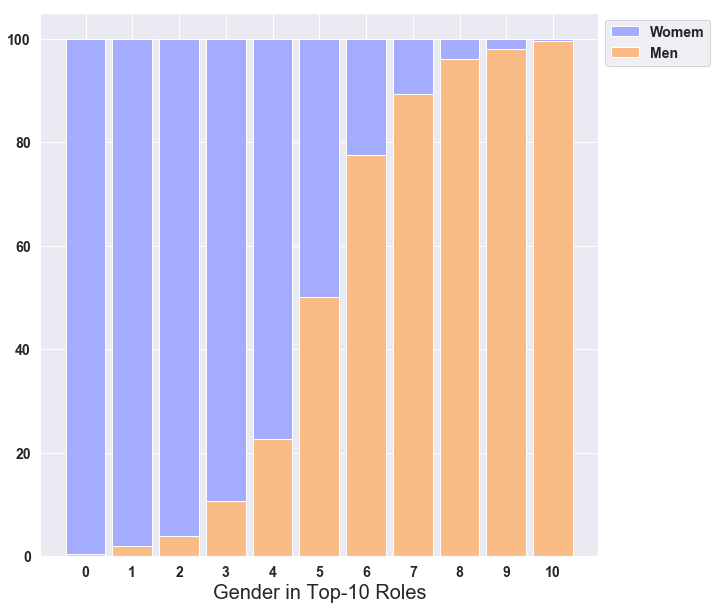

In [1490]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
plt.figure(figsize=(10,10)) 

# Data
r = [0,1,2,3,4,5,6,7,8,9,10]
raw_data = {'male': hist_df["M"],'female': hist_df["F"]}
df = pd.DataFrame(raw_data)

# From raw value to percentage
totals = [i+j for i,j in zip(df['male'], df['female'])]
mBars = [i / j * 100 for i,j in zip(df['male'], totals)]
fBars = [i / j * 100 for i,j in zip(df['female'], totals)]
print(mBars)
print(fBars)

# plot
barWidth = 0.85
names = [0,1,2,3,4,5,6,7,8,9,10]
# Create green Bars
# Create orange Bars
plt.bar(r, fBars, bottom=mBars, color='#a3acff', edgecolor='white', width=barWidth, label="Womem")


plt.bar(r, mBars, bottom=0, color='#f9bc86', edgecolor='white', width=barWidth, label="Men")

# Create blue Bars

# Custom x axis
plt.xticks(r, names, size=14)
plt.yticks(size=14)

plt.xlabel("Gender in Top-10 Roles", size=20)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, prop={'size':14})

# Show graphic
plt.show()


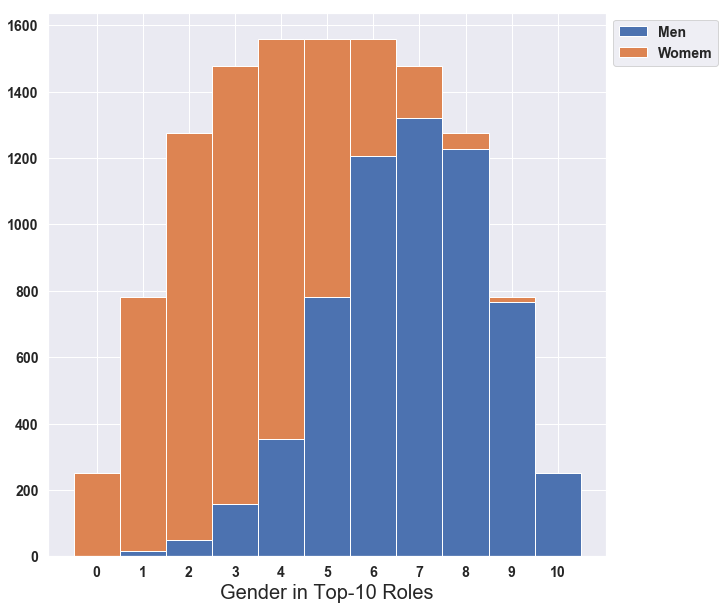

In [1494]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
plt.figure(figsize=(10,10)) 

# y-axis in bold
rc('font', weight='bold')

# Values of each group
bars1 = hist_df["M"]
bars2 = hist_df["F"]
bars3 = [25, 3, 23, 25, 17]

# Heights of bars1 + bars2 (TO DO better)
bars = hist_df["M"] + hist_df["F"]

# The position of the bars on the x-axis
r = [0,1,2,3,4,5,6,7,8,9,10]

# Names of group and bar width
names = [0,1,2,3,4,5,6,7,8,9,10]
barWidth = 1

# Create brown bars
plt.bar(r, bars1,  edgecolor='white', width=barWidth, label="Men")
# Create green bars (middle), on top of the firs ones
plt.bar(r, bars2, bottom=bars1,  edgecolor='white', width=barWidth, label="Womem")
# Create green bars (top)
# plt.bar(r, bars3, bottom=bars, color='#2d7f5e', edgecolor='white', width=barWidth)

# Custom X axis
plt.xticks(r, names, fontweight='bold', size=14)
plt.yticks(size=14)

plt.xlabel("Gender in Top-10 Roles", size=20)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, prop={'size':14})

# Show graphic
plt.show()


Text(0.5, 0, 'Women in Top-10 Roles')

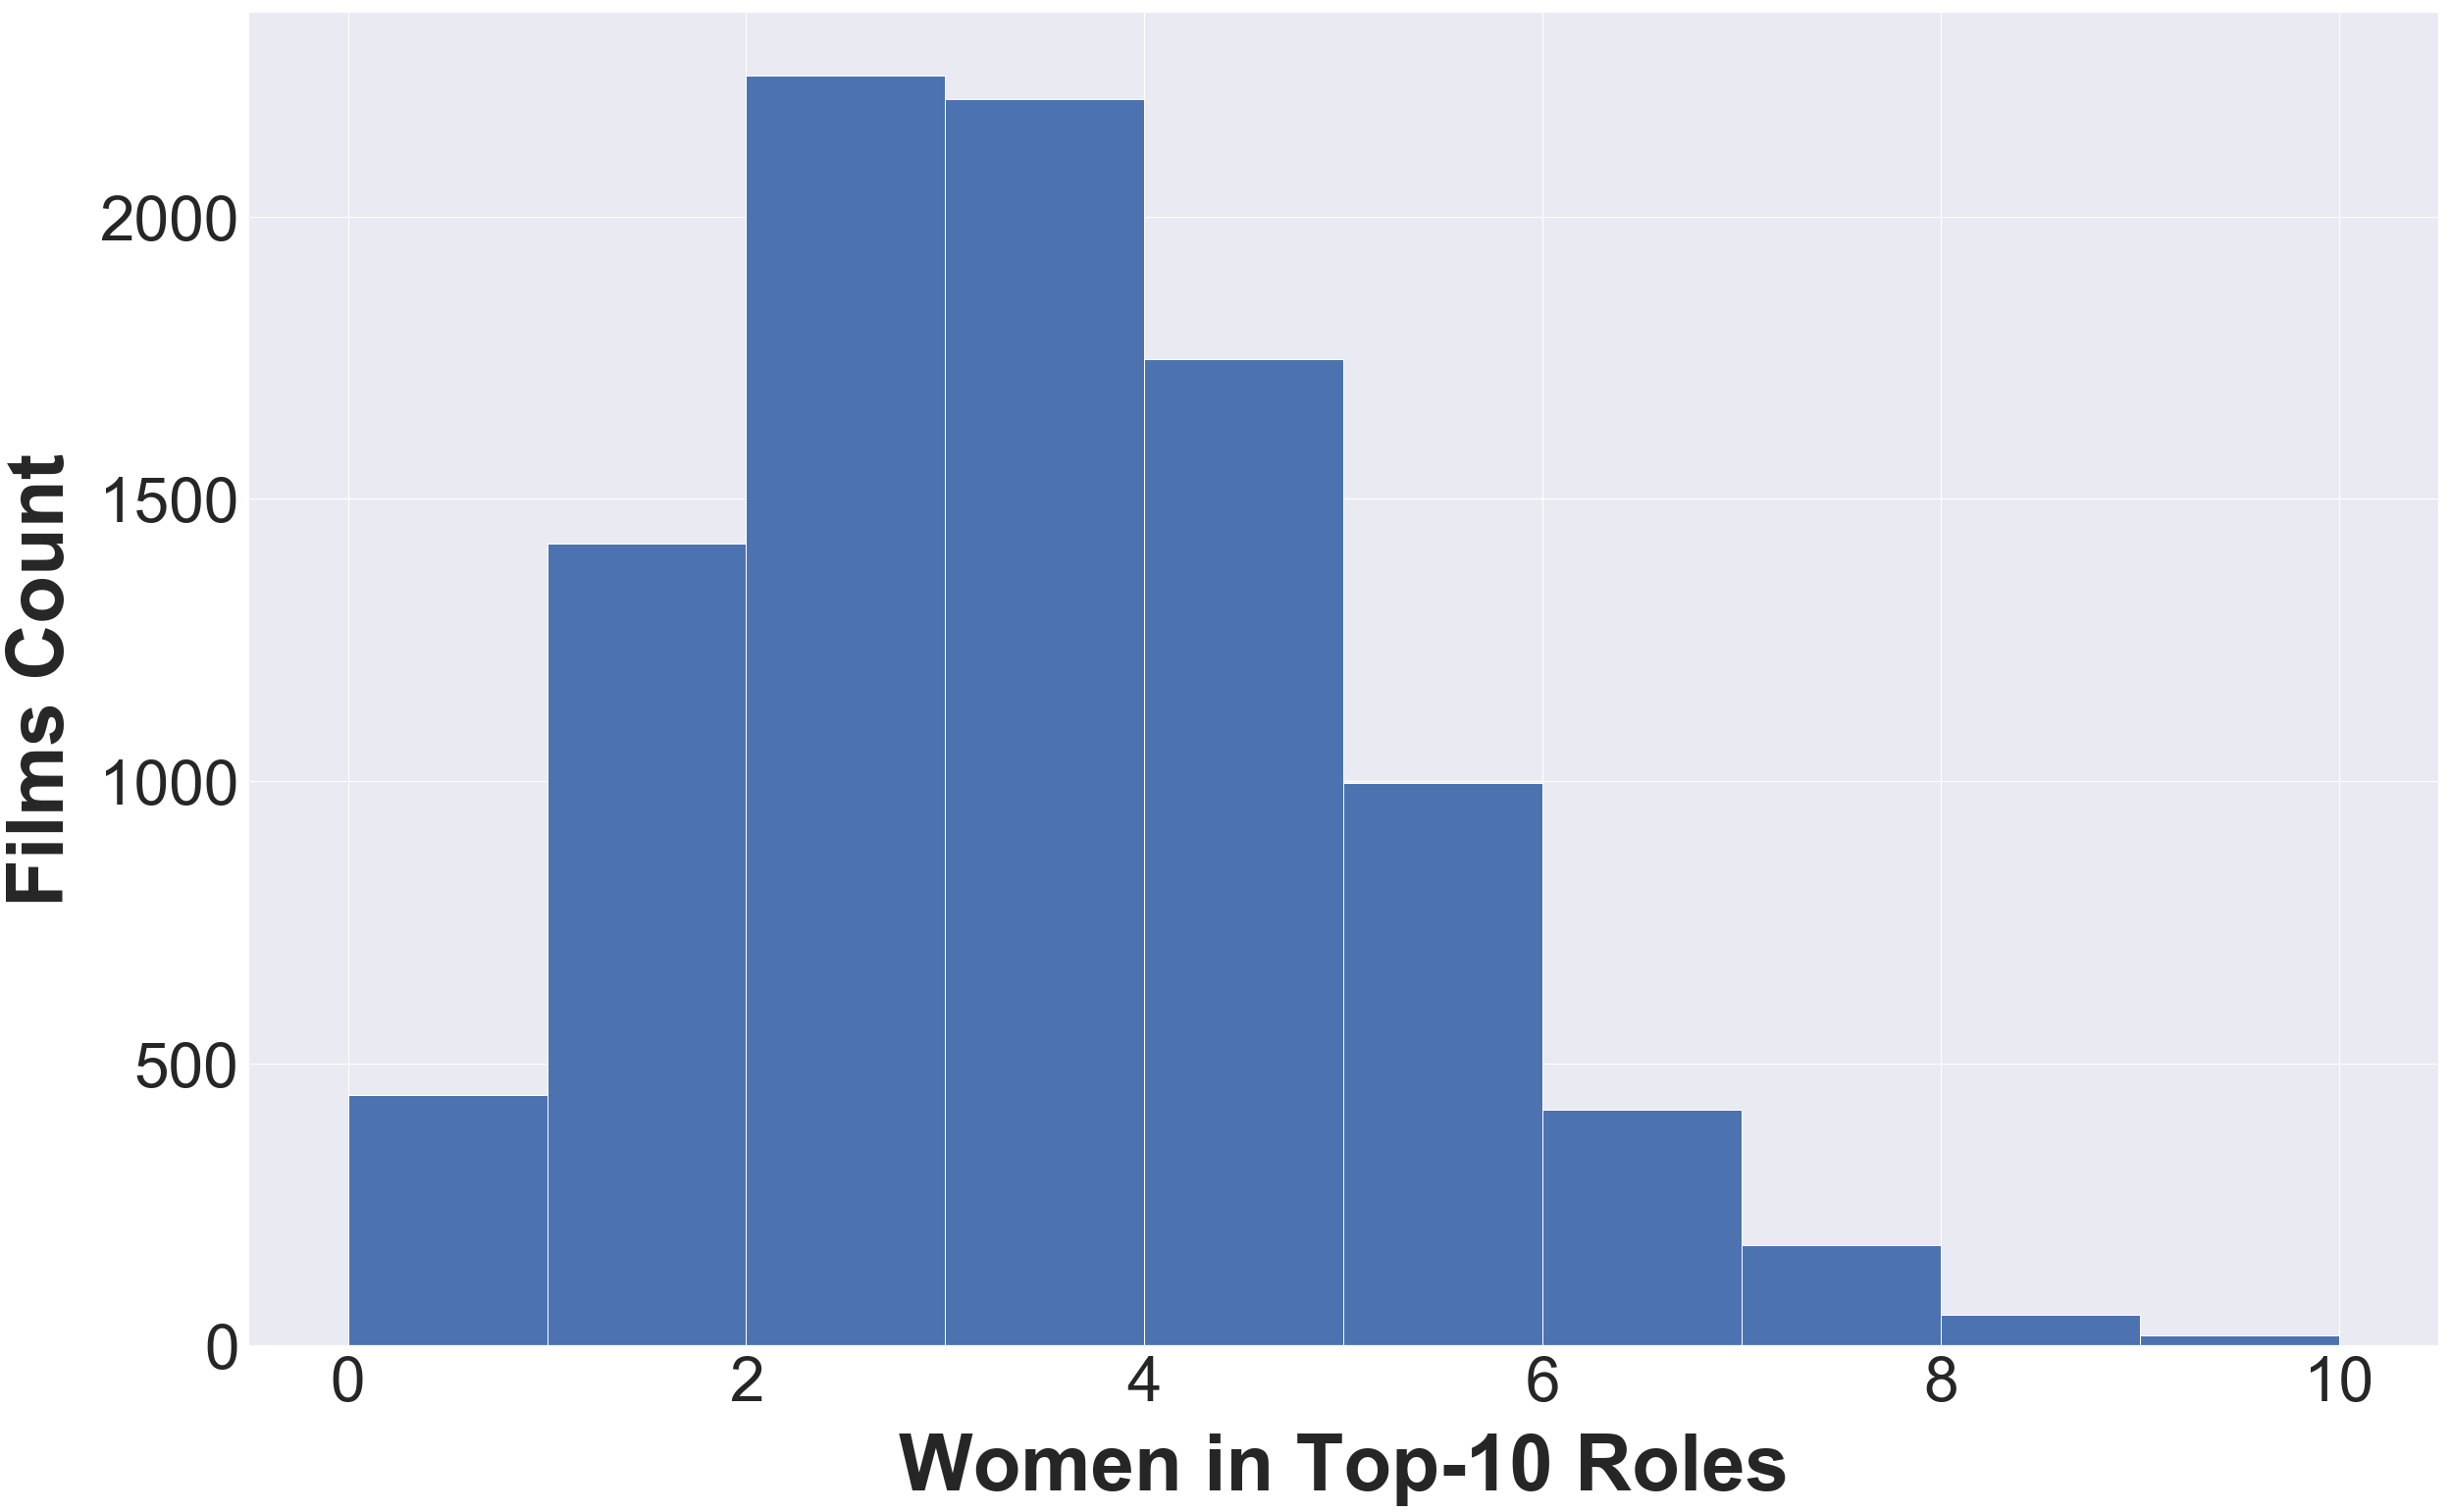

In [1428]:
x = pager_gcentrality.groupby("movie_name").sum()["F"].hist(bins=11,figsize=(40, 25), ylabelsize=64, xlabelsize=64)

# Set x-axis label
x.set_ylabel("Films Count", labelpad=20, weight='bold', size=80)

# Set y-axis label
x.set_xlabel("Women in Top-10 Roles", labelpad=20, weight='bold', size=80)

Text(0.5, 0, 'Men in Top-10 Roles')

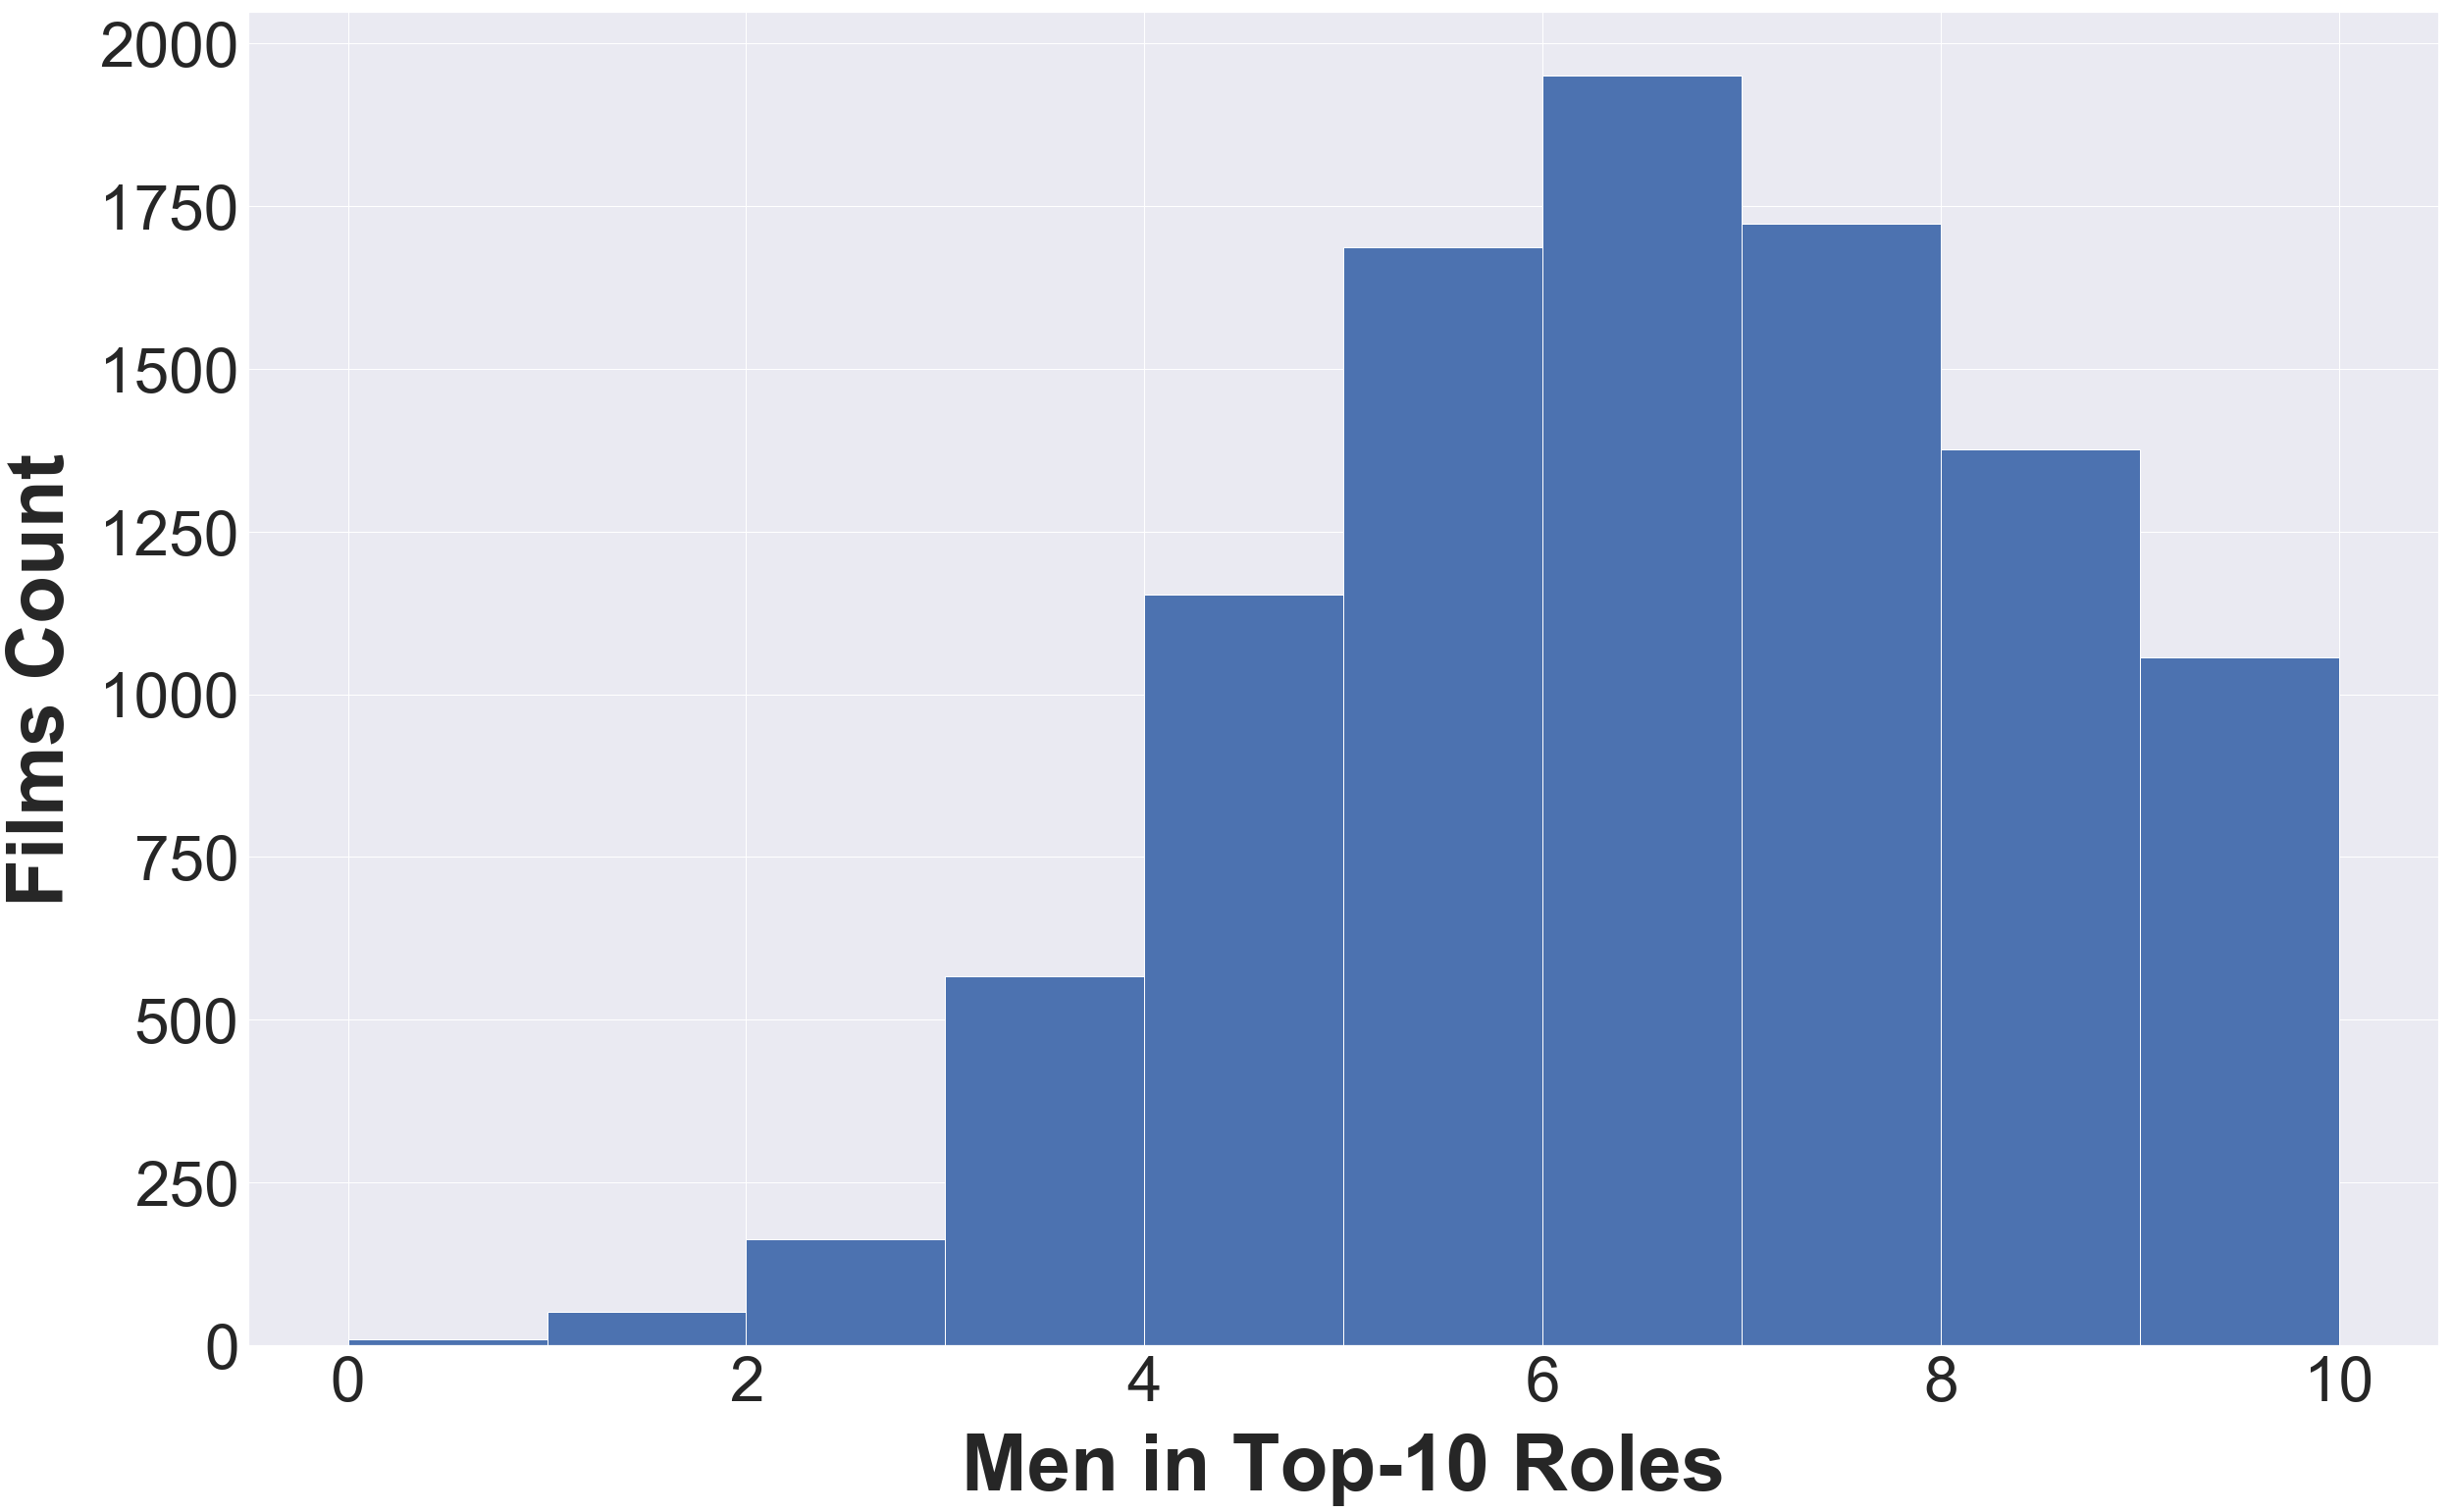

In [1429]:
x = pager_gcentrality.groupby("movie_name").sum()["M"].hist(bins=11,figsize=(40, 25),ylabelsize=64, xlabelsize=64)
# Set x-axis label
x.set_ylabel("Films Count", labelpad=20, weight='bold', size=80)

# Set y-axis label
x.set_xlabel("Men in Top-10 Roles", labelpad=20, weight='bold', size=80)

In [1392]:
m = pager_gcentrality.groupby("movie_name").sum()["M"].value_counts()

In [1393]:
f = pager_gcentrality.groupby("movie_name").sum()["F"].value_counts()

In [1497]:
f_overtime_temp = pager_gcentrality.groupby("movie_name").agg(['sum','count'])

In [1498]:
f_overtime = pd.DataFrame()
f_overtime["F"] = f_overtime_temp["F"]["sum"]
f_overtime["year"] = f_overtime_temp["year"]["sum"]/f_overtime_temp["year"]["count"]

In [1504]:
f_overtime.groupby("year").agg(["count","mean"]).tail(60)

F          
       count      mean
year                  
1959.0    36  2.500000
1960.0    37  2.891892
1961.0    29  2.482759
1962.0    32  2.406250
1963.0    33  2.696970
1964.0    33  3.000000
1965.0    30  2.533333
1966.0    39  2.256410
1967.0    42  2.404762
1968.0    42  1.976190
1969.0    35  2.142857
1970.0    41  2.658537
1971.0    37  2.810811
1972.0    39  2.256410
1973.0    39  2.307692
1974.0    36  2.611111
1975.0    46  2.543478
1976.0    45  2.488889
1977.0    40  3.425000
1978.0    48  2.812500
1979.0    52  2.596154
1980.0    61  2.377049
1981.0    59  2.525424
1982.0    66  3.090909
1983.0    68  2.558824
1984.0    80  2.850000
1985.0    82  2.682927
1986.0   101  2.633663
1987.0    98  2.714286
1988.0   110  3.090909
1989.0   104  2.644231
1990.0   108  2.796296
1991.0   122  2.918033
1992.0   113  2.690265
1993.0   145  2.558621
1994.0   144  2.652778
1995.0   165  2.818182
1996.0   166  2.903614
1997.0   152  2.881579
1998.0   182  2.890110
1999.0   179  3.100559
2000.0   212  2.995283
2001.0   217  2.907834
2002.0   218  2.844037
2003.0   214  2.813084
2004.0   232  3.094828
2005.0   264  3.189394
2006.0   297  3.131313
2007.0   325  3.178462
2008.0   347  3.057637
2009.0   369  3.214092
2010.0   340  3.076471
2011.0   357  3.162465
2012.0   385  2.981818
2013.0   413  3.084746
2014.0   417  3.119904
2015.0   344  3.226744
2016.0   375  3.200000
2017.0   341  3.348974
2018.0   192  3.494792

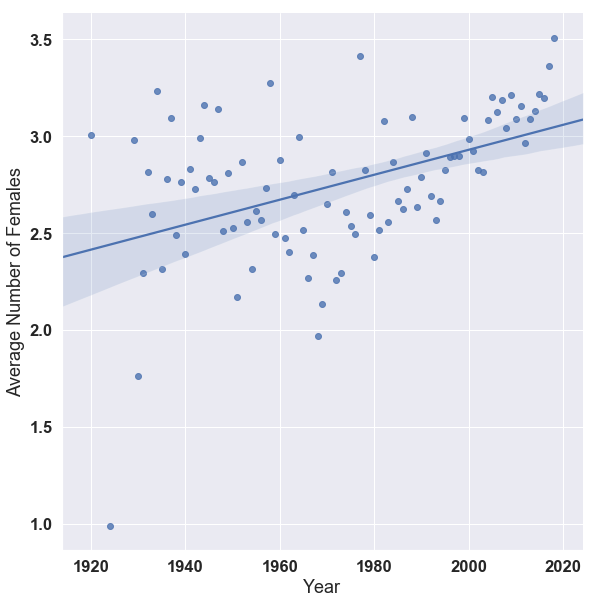

In [1519]:
sea = f_overtime[["year", "F"]].groupby("year").mean()
sea["year"] = sea.index.values
# sea = sea[sea["year"] > 1950]
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.5) 

# Make a custom palette with gendered colors
pal = dict(male="#6495ED", female="#F08080")

# Show the survival proability as a function of age and sex
g = sns.lmplot(x="year", y="F", data=sea[["year","F"]],
               palette=pal, y_jitter=.02)
# g.set(xlim=(0, 80), ylim=(-.05, 1.05))
g.fig.set_size_inches(10,10)
g.set(xlabel='Year', ylabel='Average Number of Females')


In [1502]:
!python -m pip install statsmodels

### Bechdel

#### Data Downloading

In [485]:
import requests

r = requests.get("http://bechdeltest.com/api/v1/getAllMovies")

In [489]:
bechdel = r.json()

In [496]:
bechdel_df = pd.DataFrame(bechdel)

#### ML

In [1713]:
from turicreate import SFrame

In [1714]:
bechdel = SFrame.read_csv("../data/bechdel.csv", column_type_hints={"imdbid": str})

Finished parsing file /Users/dimakagan/Projects/subs2graph/data/bechdel.csv

Parsing completed. Parsed 100 lines in 0.05764 secs.

These column type hints were not used: X1

Finished parsing file /Users/dimakagan/Projects/subs2graph/data/bechdel.csv

Parsing completed. Parsed 7871 lines in 0.037294 secs.

In [1715]:
bechdel.sort("year", False)

X1,id,imdbid,rating,title,year
7870,8423,0365545,3,Nappily Ever Aftet,2018
7869,8414,3829266,1,"Predator, The",2018
7868,8397,7282468,0,Burning,2018
7867,8385,3846674,3,To All the Boys I&#39;veLoved Before ...,2018
7866,8381,2231461,3,Rampage,2018
7865,8369,4779682,3,"Meg, The",2018
7864,8365,6791096,3,I Feel Pretty,2018
7863,8349,7279188,3,Woman at War,2018
7862,8345,7424200,3,Teen Titans Go! To theMovies ...,2018
7861,8337,6911608,3,Mamma Mia! Here We GoAgain ...,2018


In [1716]:
bechdel["tconst"] = "tt" + bechdel["imdbid"]

In [ ]:
triagles_gender

In [1720]:
bechdel_imdb = imdb_data.title.join(bechdel)

In [1724]:
bechdel_imdb = bechdel_imdb[bechdel_imdb["titleType"] == "movie"]

In [1721]:
triagles_gender["1"]= triagles_gender["X.0"]=="M"
triagles_gender["2"]= triagles_gender["X.1"]=="M"
triagles_gender["3"]= triagles_gender["X.2"]=="M"
triagles_gender["total"] = triagles_gender["1"] + triagles_gender["2"] + triagles_gender["3"]

In [1722]:
from turicreate import aggregate as agg
moive_triangle = triagles_gender.groupby(["tconst","total"], operations={'count': agg.COUNT()})
# type(moive_triangle)
traingles_at_movie = moive_triangle.to_dataframe().pivot_table(index=['tconst'], values ="count", columns='total', aggfunc= lambda x: x)
traingles_at_movie = traingles_at_movie.fillna(0)

In [1723]:
traingles_at_movie["tconst"] = traingles_at_movie.index.values

In [1725]:
bechdel_triangles = SFrame(traingles_at_movie).join(bechdel_imdb, {"tconst":"tconst"})

In [1726]:
graph_features = SFrame.read_csv("../temp/graph_features.csv")

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/graph_features.csv

Parsing completed. Parsed 100 lines in 0.080066 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,int,float,float,float,float,float,float,float,float,float,float,float,float,float,float,int,int,float,int,str,int,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/graph_features.csv

Parsing completed. Parsed 11421 lines in 0.118676 secs.

In [1727]:
gender_centrality_movies = gender_centrality[gender_centrality["rank_pagerank"] < 11].groupby("movie_name").agg(["sum","count"])
gender_centrality_movies[["F", "year"]]["year"]
female_in_top_10 =  pd.DataFrame()
female_in_top_10["F_top10"] = gender_centrality_movies["F"]["sum"] / gender_centrality_movies["F"]["count"]
female_in_top_10["year"] = gender_centrality_movies["year"]["sum"] / gender_centrality_movies["year"]["count"]
female_in_top_10["movie_name"] = gender_centrality_movies.index.str.replace(" - roles", "")
female_in_top_10["year"] = female_in_top_10["year"].astype(int)

In [1728]:
graph_features = graph_features.join(SFrame(female_in_top_10), on={"movie_name":"movie_name", "year":"year"})

In [1729]:
graph_features = graph_features[graph_features["node_number"] > 5]

In [1730]:
bechdel_ml = graph_features.join(bechdel_triangles, on={"movie_name":"primaryTitle", "year":"year"})

In [1731]:
len(bechdel_ml)

3303

In [1732]:
bechdel_ml["rating"] = bechdel_ml["rating"] ==3

In [1733]:
bechdel_ml = bechdel_ml.to_dataframe()

In [1734]:
bechdel_ml["genres"] = bechdel_ml["genres"].apply(lambda x: x.split(","))

In [1735]:
for genre in set().union(*bechdel_ml.genres.values):
    bechdel_ml[genre] = bechdel_ml.apply(lambda _: int(genre in _.genres), axis=1)

In [1736]:
bechdel_ml.to_csv("bechdel_ml.csv", index=False)

In [1748]:
bechdel_ml = pd.DataFrame.from_csv("bechdel_ml.csv", index_col=None)

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [1758]:
bechdel_ml["titleType"].value_counts()

movie    3303
Name: titleType, dtype: int64

In [1738]:
bechdel_ml= bechdel_ml.sort_values("year")

In [1739]:
titles = bechdel_ml.pop('title')

In [1740]:
bechdel_ml = bechdel_ml.drop(["X1", "genres","imdbid" ,"originalTitle",'startYear', "movie_name",'endYear', 'isAdult', 'tconst', 'titleType',
       'id'], axis=1)

In [1741]:
bechdel_ml = bechdel_ml.fillna(0)

In [1742]:
np.any(np.isnan(bechdel_ml))

False

In [1743]:
bechdel_ml["total_tir"] = bechdel_ml["0"]+bechdel_ml["1"]+ bechdel_ml["2"]+ bechdel_ml["3"]
for i in range(4):
    bechdel_ml[f"{i}%"] = bechdel_ml[str(i)]/bechdel_ml["total_tir"]

In [1744]:
y = bechdel_ml.pop("rating")


In [1745]:
n_valid = 1000
X_valid, X_train  = split_vals(bechdel_ml, n_valid)
y_valid, y_train = split_vals(y, n_valid)

In [1746]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=100,max_depth=5,  random_state=1)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.46687959081872155, 0.5319774431308154, 0.7820234476769431, 0.717]


In [1747]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_valid, m.predict_proba(X_valid)[:, 1])

0.8035784189094842

In [894]:
import turicreate as tc
sf_train = SFrame(X_train)
sf_train["label"] = y_train
test_data = SFrame(X_valid)
test_data["label"] = y_valid

model = tc.boosted_trees_classifier.create(sf_train, target='label',
                                           max_iterations=30,step_size=0.1,
                                           max_depth = 4,column_subsample=0.5,validation_set=test_data, metric="auc")

# Save predictions to an SFrame (class and corresponding class-probabilities)
# predictions = model.classify(test_data)

# Evaluate the model and save the results into a dictionary
results = model.evaluate(test_data)

Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 2437

Number of classes           : 2

Number of feature columns   : 72

Number of unpacked features : 72

+-----------+--------------+---------------------------+-----------------------------+

| Iteration | Elapsed Time | Training Area Under Curve | Validation Area Under Curve |

+-----------+--------------+---------------------------+-----------------------------+

| 1         | 0.011038     | 0.811994                  | 0.779577                    |

| 2         | 0.016018     | 0.820160                  | 0.789547                    |

| 3         | 0.020311     | 0.827194                  | 0.792620                    |

| 4         | 0.024898     | 0.831697                  | 0.792758                    |

| 5         | 0.029757     | 0.836902                  | 0.795284                    |

| 10        | 0.052134     | 0.847713                  | 0.798919                    |

| 30        | 0.139005     | 0.876980                  | 0.800066                    |

+-----------+--------------+---------------------------+-----------------------------+

In [859]:
results

{'accuracy': 0.707, 'auc': 0.7880161066886383, 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        0        |  124  |
 |      1       |        1        |  425  |
 |      0       |        1        |  169  |
 |      0       |        0        |  282  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns], 'f1_score': 0.7436570428696413, 'log_loss': 0.5598957936782983, 'precision': 0.7154882154882155, 'recall': 0.7741347905282332, 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+-----+-----+
 | threshold | fpr | tpr |  p  |  n  |
 +-----------+-----+-----+-----+-----+
 |    0.0    | 1.0 | 1.0 | 549 | 451 |
 |   1e-05   | 1.0 | 1.0 | 549 | 451 |
 |   2e-05   | 1.0 | 1.0 | 549 | 451 |
 |   3e-05

In [835]:
def ranking_precision_score(y_true, y_score, k=10):
    """Precision at rank k
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array-like, shape = [n_samples]
        Predicted scores.
    k : int
        Rank.
    Returns
    -------
    precision @k : float
    """
    unique_y = np.unique(y_true)

    if len(unique_y) > 2:
        raise ValueError("Only supported for two relevance levels.")

    pos_label = unique_y[1]
    n_pos = np.sum(y_true == pos_label)
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    print(len(y_true))
    n_relevant = np.sum(y_true == pos_label)

    # Divide by min(n_pos, k) such that the best achievable score is always 1.0.
    return float(n_relevant) / min(n_pos, k)


In [836]:
import csv, os
from operator import itemgetter
from random import shuffle
from copy import deepcopy


class PrecisionKExtractor:
    def __init__(self, actual, predicted, probability):
        self._data = SFrame({"actual": actual, "predicted": predicted, "probability": probability})
        self._data = self._data.sort(["probability", "predicted"], ascending=False)


    def calculate_precision_k(self):
        k = float(1)
        current_sum = float(0)
        precision_k_list = []
        for n,row in enumerate(self._data):
            if row["predicted"] in [1, 0]:
                if row["actual"] == 1 and row["predicted"] ==1:
                    current_sum += 1
            precision_k_list.append([n+1, current_sum / self._data["predicted"][:n+1].sum()])
        return precision_k_list

probas  = m.predict_proba(X_valid)[:, 1]
prediction = np.where(probas > 0.5, 1, 0)
pke = PrecisionKExtractor(y_valid.values, prediction ,m.predict_proba(X_valid)[:, 1])
# pke.extract_batch(True)


In [837]:
debug = SFrame({"actual": y_valid.values, "predicted": prediction, "probability": m.predict_proba(X_valid)[:, 1], "title":split_vals(titles, n_valid)[0]})

In [838]:
patk = pke.calculate_precision_k()

In [839]:
patk[100]

[101, 0.9405940594059405]

In [1535]:
patk_df = pd.DataFrame(patk)
patk_df = patk_df.rename(columns={0:"K", 1: "Precision"})

In [1536]:
patk_df.columns

Index(['K', 'Precision'], dtype='object')

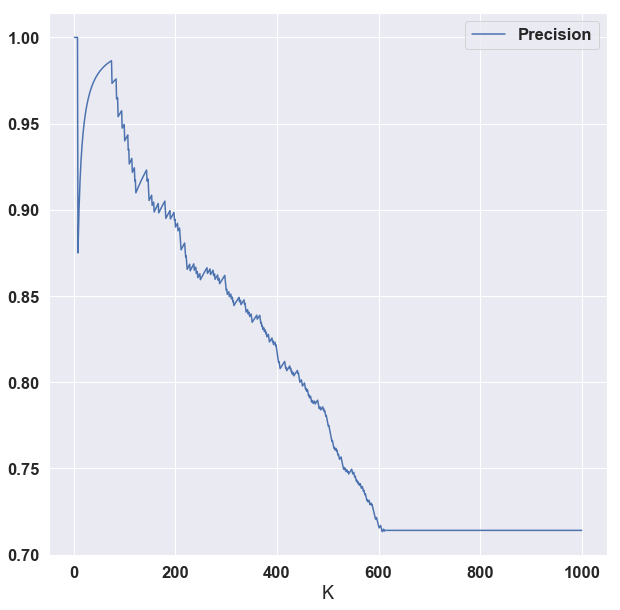

In [1537]:
patk_df.plot(0, 1, figsize=(10, 10))

In [918]:
debug = debug.sort("probability")

In [926]:
(debug[(debug["predicted"] ==0) & (debug["actual"] ==1) ])[0:]

actual,predicted,probability,title
1,0,0.24768081856614294,"China Syndrome, The"
1,0,0.2522618090324377,Advise &amp; Consent
1,0,0.2899268213747625,Hidden Agenda
1,0,0.2948506884292374,Inherit the Wind
1,0,0.2994037622604425,Hudson Hawk
1,0,0.3098054213711096,Polyester
1,0,0.3140809666280939,House of Games
1,0,0.3248747751196035,Street Fighter
1,0,0.3273504834708276,Bullets or Ballots
1,0,0.32772216664562426,Species


In [1567]:
(debug[(debug["predicted"] ==1) & (debug["actual"] ==0) ])[-10:]

actual,predicted,probability,title
0,1,0.8792432448796201,Three Faces of Eve
0,1,0.8831366990101179,Singles
0,1,0.8842371511857805,Terms of Endearment
0,1,0.8850489281339385,What About Bob?
0,1,0.8859819631223079,Radio Days
0,1,0.8870562364953188,Somewhere in Time
0,1,0.8902444900033426,Stella
0,1,0.8915309257628504,"Letter, The"
0,1,0.8953419959087949,10 Rillington Place
0,1,0.9276649425170711,Fanny and Alexander


In [842]:
debug[debug["title"] =='Net, The']

actual,predicted,probability,title
1,0,0.35326901958290746,"Net, The"


In [1703]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index=X_train.columns.values,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
1%,0.137205
0%,0.108298
3%,0.106385
0,0.073470
F_top10,0.071717
1,0.065593
3,0.043518
f_count,0.035075
2%,0.019857
m_count,0.010473


Confusion matrix, without normalization
[[280 172]
 [114 434]]
Normalized confusion matrix
[[0.62 0.38]
 [0.21 0.79]]


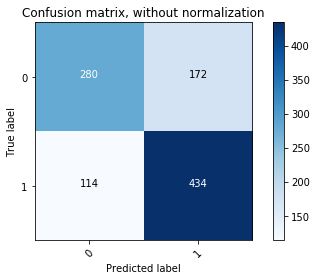

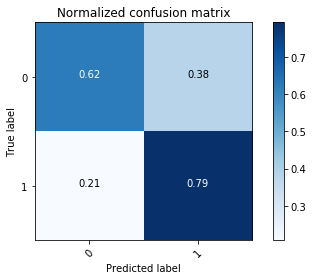

In [232]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


class_names = [0, 1]

y_pred = m.predict(X_valid)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_valid, y_pred ,labels=class_names)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
imdb_data.

### T-test

In [1004]:
from scipy.stats import ttest_ind, kstest

In [1081]:
x = np.linspace(-15, 15, 9)
loc, scale = 10, 1
s = np.random.exponential( scale, 10000)
kstest(df.birthYear, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

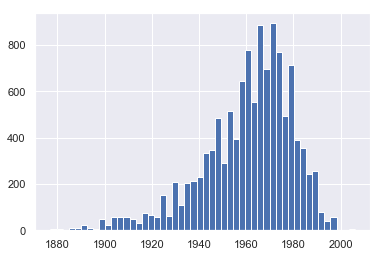

In [1079]:
df.birthYear.hist(bins=50)

In [1091]:
from scipy import stats
pts = 1000
np.random.seed(28041990)
a = np.random.normal(0, 1, size=pts)
b = np.random.normal(2, 1, size=pts)
x = np.concatenate((a, b))
k2, p = stats.normaltest(s)
alpha = 0.05
print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.307157
The null hypothesis cannot be rejected


In [1092]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# generate univariate observations
data = 5 * randn(100) + 50
# normality test
stat, p = shapiro(male.averageRating)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.991, p=0.000
Sample does not look Gaussian (reject H0)


/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/scipy/stats/morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [1089]:
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)

In [1049]:
ttest_ind(male.averageRating.values, s)

Ttest_indResult(statistic=452.6674903311564, pvalue=0.0)

By Gender:

In [1051]:
df.Mystery

493      0
494      0
495      0
496      0
497      0
498      0
499      0
500      0
501      0
528      0
533      1
529      0
532      0
531      0
530      0
525      0
526      1
527      0
507      0
509      1
510      0
511      0
512      0
508      1
111      1
110      0
109      0
104      0
107      0
106      0
        ..
4267     0
4268     0
10414    0
10415    0
2549     0
9226     0
9225     0
2975     0
2974     0
2973     0
2972     0
2971     0
8577     1
8576     0
8575     0
8574     0
5571     0
5568     0
5569     1
5570     0
6333     0
6332     0
6334     0
1737     0
1736     0
1734     0
1735     0
6128     1
6129     0
6130     0
Name: Mystery, Length: 11975, dtype: int64

In [1040]:
for col in df.columns.values:
    if "gender" not in col:
        print(f"{col}: {ttest_ind(male[col], female[col])}")

averageRating: Ttest_indResult(statistic=9.86869855039621, pvalue=6.956595354519088e-23)
betweenness: Ttest_indResult(statistic=13.779684833161152, pvalue=7.170123649010226e-43)
betweenness_weight: Ttest_indResult(statistic=8.89665172365582, pvalue=6.577791878817025e-19)
birthYear: Ttest_indResult(statistic=-25.86882016545842, pvalue=1.2647094809506116e-143)
closeness: Ttest_indResult(statistic=6.880955414087381, pvalue=6.241581808596746e-12)
clustering: Ttest_indResult(statistic=-10.41654432124654, pvalue=2.672660100747721e-25)
deathYear: Ttest_indResult(statistic=13.238774966502534, pvalue=9.961306494267046e-40)
degree: Ttest_indResult(statistic=6.104321764222663, pvalue=1.0643210649625146e-09)
degree_centrality: Ttest_indResult(statistic=7.461216319915628, pvalue=9.165064725877648e-14)
movie_rating: Ttest_indResult(statistic=6.160800904757649, pvalue=7.470029476980732e-10)
pagerank: Ttest_indResult(statistic=10.811853368088062, pvalue=4.0358457357826e-27)
pagerank_weight: Ttest_indR

By genere:

In [161]:
for g in genres:
    print(g)
    for col in df.columns.values:
        if "gender" not in col:
            print(f"{col}: {ttest_ind(male[male[g] ==1][col], female[female[g] ==1][col])}")

Sci-Fi
averageRating: Ttest_indResult(statistic=2.878437280819165, pvalue=0.004088059565943305)
betweenness: Ttest_indResult(statistic=4.4996291792099425, pvalue=7.66896196147579e-06)
birthYear: Ttest_indResult(statistic=-9.858661504073039, pvalue=7.105041568554806e-22)
closeness: Ttest_indResult(statistic=2.5722957338637724, pvalue=0.010256834542517374)
clustering: Ttest_indResult(statistic=-3.3810096311148428, pvalue=0.0007522722396612554)
count: Ttest_indResult(statistic=4.097776656462591, pvalue=4.5353813867359104e-05)
deathYear: Ttest_indResult(statistic=4.2011514042390345, pvalue=2.9112593252964855e-05)
degree: Ttest_indResult(statistic=2.2234912824604782, pvalue=0.02642228782557747)
degree_centrality: Ttest_indResult(statistic=2.788844106965154, pvalue=0.005397644496793122)
runtimeMinutes: Ttest_indResult(statistic=1.173110027482423, pvalue=0.24105205531944865)
startYear: Ttest_indResult(statistic=-2.4747374438295173, pvalue=0.013510777011626104)
total_weight: Ttest_indResult(st

art_department: Ttest_indResult(statistic=-1.5549705342184899, pvalue=0.1202154552921671)
animation_department: Ttest_indResult(statistic=0.7527236174332852, pvalue=0.4517629134921668)
stunts: Ttest_indResult(statistic=1.0652038640343788, pvalue=0.28699689779190196)
sound_department: Ttest_indResult(statistic=nan, pvalue=nan)
casting_department: Ttest_indResult(statistic=-1.3286914217919525, pvalue=0.18420114037502272)
editorial_department: Ttest_indResult(statistic=0.7527236174332852, pvalue=0.4517629134921668)
cinematographer: Ttest_indResult(statistic=0.659587179241245, pvalue=0.509644716203177)
music_department: Ttest_indResult(statistic=1.70148680251074, pvalue=0.08910936973146476)
writer: Ttest_indResult(statistic=4.092622460028543, pvalue=4.5488515289955205e-05)
casting_director: Ttest_indResult(statistic=-1.3286914217919525, pvalue=0.18420114037502272)
assistant_director: Ttest_indResult(statistic=1.3054520440526312, pvalue=0.1919879529354649)
miscellaneous: Ttest_indResult(sta

music_department: Ttest_indResult(statistic=-0.046654676685173986, pvalue=0.9627999253413528)
writer: Ttest_indResult(statistic=5.276608336981665, pvalue=1.6896885817976778e-07)
casting_director: Ttest_indResult(statistic=nan, pvalue=nan)
assistant_director: Ttest_indResult(statistic=-0.09302577894450939, pvalue=0.9259060282281152)
miscellaneous: Ttest_indResult(statistic=-0.1623371145185175, pvalue=0.8710807767287774)
Sport
averageRating: Ttest_indResult(statistic=0.6628847808927107, pvalue=0.5079049908723842)
betweenness: Ttest_indResult(statistic=3.782722609589021, pvalue=0.00018667573889088318)
birthYear: Ttest_indResult(statistic=-1.105138263611148, pvalue=0.2699706966329295)
closeness: Ttest_indResult(statistic=3.292300284228695, pvalue=0.0011104619652151924)
clustering: Ttest_indResult(statistic=-1.5417730110981023, pvalue=0.12416561625390035)
count: Ttest_indResult(statistic=3.544480183169085, pvalue=0.0004550540564269864)
deathYear: Ttest_indResult(statistic=2.2306869182449085

casting_director: Ttest_indResult(statistic=nan, pvalue=nan)
assistant_director: Ttest_indResult(statistic=1.181839848958003, pvalue=0.23737080986350953)
miscellaneous: Ttest_indResult(statistic=0.5688007495783948, pvalue=0.5695375280379378)
War
averageRating: Ttest_indResult(statistic=0.37148859251988414, pvalue=0.710646412087159)
betweenness: Ttest_indResult(statistic=0.550295741640809, pvalue=0.5826986303915076)
birthYear: Ttest_indResult(statistic=-1.6280359877407533, pvalue=0.1050094880332482)
closeness: Ttest_indResult(statistic=1.1954766301980657, pvalue=0.23324270583239834)
clustering: Ttest_indResult(statistic=-2.2697003798883233, pvalue=0.024236398233190414)
count: Ttest_indResult(statistic=1.3776769604610508, pvalue=0.1697624952103168)
deathYear: Ttest_indResult(statistic=1.779574321774342, pvalue=0.07658500042173362)
degree: Ttest_indResult(statistic=0.42308223405906586, pvalue=0.6726661543666624)
degree_centrality: Ttest_indResult(statistic=1.0741745783736034, pvalue=0.283

degree: Ttest_indResult(statistic=2.6327702867085776, pvalue=0.008527880360304805)
degree_centrality: Ttest_indResult(statistic=4.351650788174536, pvalue=1.4123990490236117e-05)
runtimeMinutes: Ttest_indResult(statistic=1.505115341332361, pvalue=0.13243668187367788)
startYear: Ttest_indResult(statistic=-2.5935608684847598, pvalue=0.009561195501534739)
total_weight: Ttest_indResult(statistic=2.3604160583569906, pvalue=0.01834048299373358)
age_filming: Ttest_indResult(statistic=15.655051307884126, pvalue=1.7679540854547936e-52)
Sci-Fi: Ttest_indResult(statistic=0.4757935002770843, pvalue=0.6342683156855458)
Drama: Ttest_indResult(statistic=-0.2604103184105882, pvalue=0.7945714351979348)
Western: Ttest_indResult(statistic=2.5254095697295815, pvalue=0.011625437408574059)
Mystery: Ttest_indResult(statistic=-2.934996582557932, pvalue=0.0033697621298675105)
Musical: Ttest_indResult(statistic=0.009333159999411018, pvalue=0.9925541624349179)
Biography: Ttest_indResult(statistic=1.51829988257693

cinematographer: Ttest_indResult(statistic=-0.3126468102325645, pvalue=0.7545621698331066)
music_department: Ttest_indResult(statistic=-2.314151637701449, pvalue=0.020700115251523574)
writer: Ttest_indResult(statistic=15.4298524955661, pvalue=1.6877292575540135e-52)
casting_director: Ttest_indResult(statistic=nan, pvalue=nan)
assistant_director: Ttest_indResult(statistic=2.342630811475766, pvalue=0.01918769245386967)
miscellaneous: Ttest_indResult(statistic=0.7034260166047416, pvalue=0.48182335495197026)
Romance
averageRating: Ttest_indResult(statistic=5.1612187572817, pvalue=2.6497638811543043e-07)
betweenness: Ttest_indResult(statistic=5.846322604082179, pvalue=5.692190267985636e-09)
birthYear: Ttest_indResult(statistic=-4.672182081580041, pvalue=3.14089167022254e-06)
closeness: Ttest_indResult(statistic=4.167385692039016, pvalue=3.187640006891798e-05)
clustering: Ttest_indResult(statistic=-2.479326110535476, pvalue=0.013229670912123783)
count: Ttest_indResult(statistic=5.95925405806

sound_department: Ttest_indResult(statistic=nan, pvalue=nan)
casting_department: Ttest_indResult(statistic=nan, pvalue=nan)
editorial_department: Ttest_indResult(statistic=0.616152958433322, pvalue=0.5381195990397418)
cinematographer: Ttest_indResult(statistic=-0.7112075632614437, pvalue=0.4773412334220133)
music_department: Ttest_indResult(statistic=-2.2838605319313237, pvalue=0.02286651108603455)
writer: Ttest_indResult(statistic=2.736703692857834, pvalue=0.006463007888524434)
casting_director: Ttest_indResult(statistic=nan, pvalue=nan)
assistant_director: Ttest_indResult(statistic=nan, pvalue=nan)
miscellaneous: Ttest_indResult(statistic=-0.45414934859234185, pvalue=0.6499504817968724)
Action
averageRating: Ttest_indResult(statistic=6.284455582950306, pvalue=3.760319681265387e-10)
betweenness: Ttest_indResult(statistic=8.579309350005296, pvalue=1.497614255354548e-17)
birthYear: Ttest_indResult(statistic=-17.982624421436018, pvalue=8.673552367393158e-69)
closeness: Ttest_indResult(st

soundtrack: Ttest_indResult(statistic=-4.196490096446834, pvalue=2.826431388994187e-05)
composer: Ttest_indResult(statistic=-0.2135710539442076, pvalue=0.830902791169929)
costume_department: Ttest_indResult(statistic=nan, pvalue=nan)
make_up_department: Ttest_indResult(statistic=-1.537293201717653, pvalue=0.12437569768894738)
production_manager: Ttest_indResult(statistic=nan, pvalue=nan)
producer: Ttest_indResult(statistic=4.4845571822763866, pvalue=7.710001032979436e-06)
set_decorator: Ttest_indResult(statistic=nan, pvalue=nan)
camera_department: Ttest_indResult(statistic=1.2255050218505052, pvalue=0.2205256359657554)
costume_designer: Ttest_indResult(statistic=nan, pvalue=nan)
art_department: Ttest_indResult(statistic=-0.48043092098931983, pvalue=0.6309722240518085)
animation_department: Ttest_indResult(statistic=1.3025927672983746, pvalue=0.19285999625790473)
stunts: Ttest_indResult(statistic=2.5589053631983583, pvalue=0.010571402656502653)
sound_department: Ttest_indResult(statisti

writer: Ttest_indResult(statistic=1.6554840293665334, pvalue=0.10448942075743907)
casting_director: Ttest_indResult(statistic=nan, pvalue=nan)
assistant_director: Ttest_indResult(statistic=nan, pvalue=nan)
miscellaneous: Ttest_indResult(statistic=-0.36054627627346864, pvalue=0.7200540577118866)
Horror
averageRating: Ttest_indResult(statistic=2.7789177631237556, pvalue=0.005562543108739304)
betweenness: Ttest_indResult(statistic=0.8136770552473345, pvalue=0.41603560202855683)
birthYear: Ttest_indResult(statistic=-8.36097946107795, pvalue=2.2185983477687636e-16)
closeness: Ttest_indResult(statistic=-0.22069338486018933, pvalue=0.8253790054998889)
clustering: Ttest_indResult(statistic=-1.097382964797357, pvalue=0.2727544488168593)
count: Ttest_indResult(statistic=3.2374393413853, pvalue=0.001248194007260604)
deathYear: Ttest_indResult(statistic=2.9098078510199565, pvalue=0.003701604080976994)
degree: Ttest_indResult(statistic=-0.23043437933572686, pvalue=0.8178042818939851)
degree_central

assistant_director: Ttest_indResult(statistic=0.5590905728769084, pvalue=0.5764409065034743)
miscellaneous: Ttest_indResult(statistic=0.20276150906315707, pvalue=0.8394338055889148)
Music
averageRating: Ttest_indResult(statistic=3.6007227871506315, pvalue=0.0003733719787045685)
betweenness: Ttest_indResult(statistic=2.056533343658495, pvalue=0.040628759479142)
birthYear: Ttest_indResult(statistic=-4.5994974027356665, pvalue=6.342982972973846e-06)
closeness: Ttest_indResult(statistic=1.911625172000794, pvalue=0.05691315053646241)
clustering: Ttest_indResult(statistic=-1.0826030880609578, pvalue=0.2798870805877321)
count: Ttest_indResult(statistic=3.382096981263616, pvalue=0.0008185537339969209)
deathYear: Ttest_indResult(statistic=2.286182077016959, pvalue=0.022967154165330513)
degree: Ttest_indResult(statistic=0.5786122383249016, pvalue=0.5633014882528524)
degree_centrality: Ttest_indResult(statistic=2.1095517344332153, pvalue=0.03575674306455195)
runtimeMinutes: Ttest_indResult(statis

In [1232]:
len(glob.glob(os.path.join(TEMP_PATH, f"movies/*/json/*roles.json")))

13968

In [1218]:
imdb_data.actors[imdb_data.actors["primaryName"]=="Carrie-Anne Moss"]

Columns:
	nconst	str
	averageRating	float
	count	int
	primaryName	str
	birthYear	str
	deathYear	str
	primaryProfession	str
	knownForTitles	str
	gender	str

Rows: Unknown

Data:
+-----------+--------------------+-------+------------------+-----------+-----------+
|   nconst  |   averageRating    | count |   primaryName    | birthYear | deathYear |
+-----------+--------------------+-------+------------------+-----------+-----------+
| nm0005251 | 6.8199999999999985 |   15  | Carrie-Anne Moss |    1967   |     \N    |
+-----------+--------------------+-------+------------------+-----------+-----------+
+-------------------+-------------------------------+--------+
| primaryProfession |         knownForTitles        | gender |
+-------------------+-------------------------------+--------+
|  actress,producer | tt0133093,tt0209144,tt0457... |   F    |
+-------------------+-------------------------------+--------+
[? rows x 9 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.

In [1223]:
t = SFrame.read_csv(f"{TEMP_PATH}/name.basics.tsv.gz", delimiter="\t",
                                                  na_values=["\\N"], nrows=100)

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/name.basics.tsv.gz

Parsing completed. Parsed 100 lines in 0.989886 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,int,int,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/name.basics.tsv.gz

Parsing completed. Parsed 100 lines in 0.667077 secs.

In [1231]:
t.stack("primaryProfession","primaryProfession")

nconst,primaryName,birthYear,deathYear,knownForTitles,primaryProfession
nm0000001,Fred Astaire,1899,1987,"tt0043044,tt0050419,tt0053137,tt0072308 ...",soundtrack
nm0000001,Fred Astaire,1899,1987,"tt0043044,tt0050419,tt0053137,tt0072308 ...",actor
nm0000001,Fred Astaire,1899,1987,"tt0043044,tt0050419,tt0053137,tt0072308 ...",miscellaneous
nm0000002,Lauren Bacall,1924,2014,"tt0038355,tt0037382,tt0117057,tt0071877 ...",actress
nm0000002,Lauren Bacall,1924,2014,"tt0038355,tt0037382,tt0117057,tt0071877 ...",soundtrack
nm0000003,Brigitte Bardot,1934,None,"tt0059956,tt0054452,tt0049189,tt0057345 ...",actress
nm0000003,Brigitte Bardot,1934,None,"tt0059956,tt0054452,tt0049189,tt0057345 ...",soundtrack
nm0000003,Brigitte Bardot,1934,None,"tt0059956,tt0054452,tt0049189,tt0057345 ...",producer
nm0000004,John Belushi,1949,1982,"tt0072562,tt0077975,tt0078723,tt0080455 ...",actor
nm0000004,John Belushi,1949,1982,"tt0072562,tt0077975,tt0078723,tt0080455 ...",writer


In [1225]:
t["primaryProfession"] = t["primaryProfession"].apply(lambda x: x.split(","))
t.stack("primaryProfession","primaryProfession")

In [1295]:
imdb_data.all_actors["gender"].summary()


+------------------+---------+----------+
|       item       |  value  | is exact |
+------------------+---------+----------+
|      Length      | 3440575 |   Yes    |
| # Missing Values |    0    |   Yes    |
| # unique values  |    2    |    No    |
+------------------+---------+----------+

Most frequent items:
+-------+---------+
| value |  count  |
+-------+---------+
|   M   | 2161366 |
|   F   | 1279209 |
+-------+---------+


In [1374]:
pd.Series([10, 1,2,3,3, 4,5,6,7,8,9]).rank().astype(int)

0     11
1      1
2      2
3      3
4      3
5      5
6      6
7      7
8      8
9      9
10    10
dtype: int64

In [1365]:
pd.Series([1,2,3,3,3,4, 4,5,6,6,6,6,6,7,8,9]).rank().astype(int)

0      1
1      2
2      4
3      4
4      4
5      6
6      6
7      8
8     11
9     11
10    11
11    11
12    11
13    14
14    15
15    16
dtype: int64

###### Corrolations

In [162]:
female.corr()["age_filming"].sort_values()

birthYear              -0.593557
betweenness            -0.118554
degree_centrality      -0.105639
closeness              -0.098705
Action                 -0.066089
Adventure              -0.062448
Sci-Fi                 -0.060747
Horror                 -0.045146
cinematographer        -0.043658
total_weight           -0.031718
Music                  -0.031586
Fantasy                -0.029533
soundtrack             -0.028327
music_department       -0.028225
composer               -0.027123
director               -0.026245
Thriller               -0.025282
costume_designer       -0.023651
Family                 -0.022892
runtimeMinutes         -0.015810
Romance                -0.015804
Mystery                -0.014943
assistant_director     -0.014116
Sport                  -0.012541
Musical                -0.009829
Film-Noir              -0.009606
Crime                  -0.009007
miscellaneous          -0.008788
Western                -0.003204
casting_director       -0.003013
costume_de

In [163]:
male.corr()["age_filming"].sort_values()

birthYear              -0.958584
producer               -0.051052
degree_centrality      -0.046832
closeness              -0.041025
betweenness            -0.036253
degree                 -0.036160
total_weight           -0.029098
writer                 -0.023755
cinematographer        -0.018555
art_department         -0.015864
camera_department      -0.013812
editorial_department   -0.013516
Fantasy                -0.013271
Music                  -0.012800
Horror                 -0.011247
Sci-Fi                 -0.011221
assistant_director     -0.010835
War                    -0.009415
Adventure              -0.009130
Family                 -0.008221
executive              -0.007916
Film-Noir              -0.006199
Musical                -0.005560
production_manager     -0.004631
Action                 -0.004205
Documentary            -0.003242
director               -0.003231
sound_department       -0.002554
History                -0.002526
Romance                -0.001917
clustering

In [753]:
from sklearn.model_selection import LeaveOneGroupOut

X = [1, 5, 10, 50, 60, 70, 80]
y = [0, 1, 1, 2, 2, 2, 2]
groups = [1, 1, 2, 2, 3, 3, 3]
logo = LeaveOneGroupOut()
for train, test in logo.split(X, y, groups=groups):
    print("%s %s" % (train, test))

[2 3 4 5 6] [0 1]
[0 1 4 5 6] [2 3]
[0 1 2 3] [4 5 6]


In [756]:
X = [1, 5, 10, 50, 60, 70, 80]
dy = [0, 1, 1, 2, 2, 2, 2]
groups = [1, 1, 1, 1, 3, 3, 3]
logo = LeaveOneGroupOut()
for train, test in logo.split(X, y, groups=groups):
    print("%s %s" % (train, test))

[4 5 6] [0 1 2 3]
[0 1 2 3] [4 5 6]
